In [1]:
import matplotlib
from IPython.display import display
#matplotlib.use('agg') 

import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR
from torch.autograd import Variable

import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

from utils.ACTS_helper import *
from utils.custom_classical_models import *
from utils.custom_functions import *

import os
import time
import argparse
import glob
import re

import matplotlib.pyplot as plt

# import optuna

In [2]:
def get_args():
    parser = argparse.ArgumentParser(description='training quGAN for FCS')
    
    parser.add_argument('--n_epochs', type=int, default=200, dest='n_epochs', help='number of epochs to run')
    parser.add_argument('--run_dir', type=str, default='C:\\work_local\\TBGan\\runs', dest='run_dir', help='dir to save the models')
    parser.add_argument('--data_dir', type=str, default='C:\\work_local\\TBGan\\data', dest='data_dir', help='dir to the input data')

    parser.add_argument('-s', '--seed', type=int, default=0, dest='seed', help='seed of the random generator')
    parser.add_argument('-l', '--layer', type=int, default=None, dest='layer', help='select one layer data')
    parser.add_argument('--sample_size', type=int, default=10000, dest='sample_size', help='size of the sample')

    parser.add_argument('--batch_size', type=int, default=512, dest='batch_size', help='size of the batch')
    parser.add_argument('--loss_function', type=str, choices=['cross_entropy', 'wasserstein_distance'], default='wasserstein_distance', dest='loss_function', help='loss function')
    parser.add_argument('--disc_gen_ratio', type=int, default=10, dest='disc_gen_ratio')
    parser.add_argument('--lr_gen', type=float, default=0.008, dest='lr_gen', help='generator learning rate')
    parser.add_argument('--lr_disc', type=float, default=0.001, dest='lr_disc', help='discriminator learning rate')
    parser.add_argument('--gamma', type=float, default=0.95, dest='gamma', help='decay factor of the learning rate')
    parser.add_argument('--lambda_gp', type=int, default=10, dest='lambda_gp', help='gradient penalty factor')    

    parser.add_argument('--model_name', type=str, choices=['DensityNN', 'BinaryNeuron', 'CNN'], default='DensityNN', dest='model_name', help='model_name')
    
    args = parser.parse_args([
        '--n_epochs', '200', 
        '--sample_size', '10000',
        '--batch_size', '100', 
        '--gamma', '0.995',
        '--loss_function', 'wasserstein_distance',
        '--model_name', 'CNN'
    ])
 
    return args

In [3]:
# Parameters
args = get_args()
print(args)

seed = args.seed
sample_size = args.sample_size

n_epochs = args.n_epochs
batch_size = args.batch_size
loss_function = args.loss_function
disc_gen_ratio = args.disc_gen_ratio
lr_gen = args.lr_gen
gen_gamma = args.gamma
lr_disc = args.lr_disc
disc_gamma = args.gamma
lambda_gp = args.lambda_gp

run_dir = args.run_dir
data_dir = args.data_dir

model_name = args.model_name

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print(cuda)
if loss_function == 'cross_entropy':
    parameter_config = f'batch{batch_size}_gamma{args.gamma}_ce'
elif loss_function == 'wasserstein_distance':
    parameter_config = f'batch{batch_size}_gamma{args.gamma}_wd'

# experiment = f'{parameter_config}/s{seed}'

Namespace(n_epochs=200, run_dir='C:\\work_local\\TBGan\\runs', data_dir='C:\\work_local\\TBGan\\data', seed=0, layer=None, sample_size=10000, batch_size=100, loss_function='wasserstein_distance', disc_gen_ratio=10, lr_gen=0.008, lr_disc=0.001, gamma=0.995, lambda_gp=10, model_name='CNN')
True


Processing C:\work_local\TBGan\data\cluster_epoch0.npy
Processing C:\work_local\TBGan\data\cluster_epoch1.npy
Initializing ACTS 1D dataset ...
Shape of the dataset is:  (10000, 8, 8, 11)
length of the training set: 10000
length of the validation set: 0


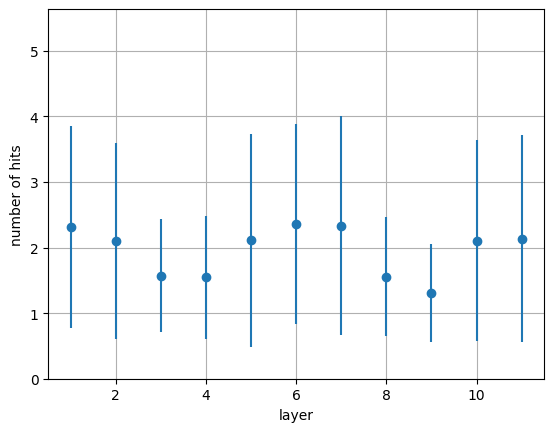

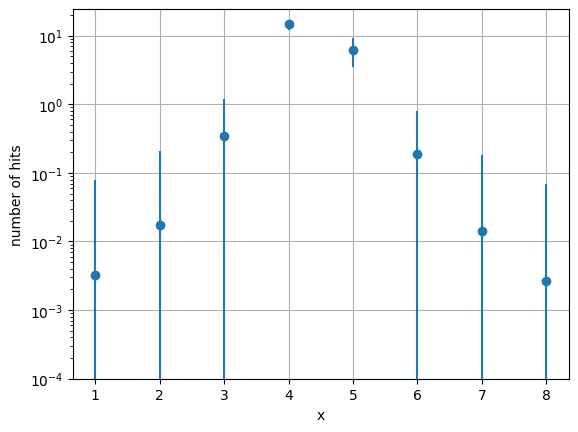

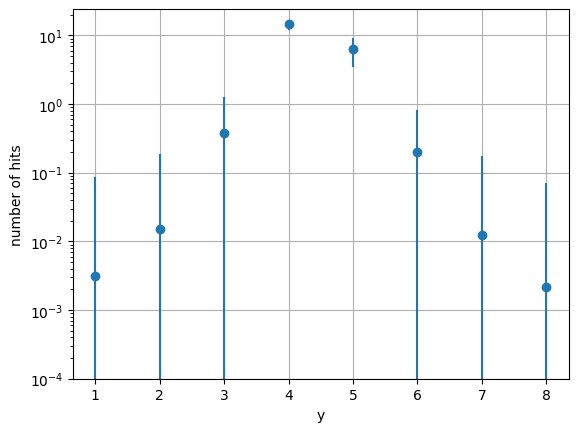

In [4]:
# Load the dataset
input_fn = f'{data_dir}/*.npy'
ACTS_dataset = ACTS(input_fn, sample_size=sample_size, min_fraction = 0.001)

train_dataset, validation_dataset = random_split(ACTS_dataset, [sample_size, 0], torch.Generator().manual_seed(42))
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(f'length of the training set: {len(train_dataset)}')
print(f'length of the validation set: {len(validation_dataset)}')

show_mean_std(ACTS_dataset.pixel_hit, axis=(1,2), xlabel='layer')
show_mean_std(ACTS_dataset.pixel_hit, axis=(2,3), xlabel='x', log=True)
show_mean_std(ACTS_dataset.pixel_hit, axis=(1,3), xlabel='y', log=True)

real_prob, _ = cal_mean_std(ACTS_dataset.pixel_hit)
real_prob = real_prob.reshape(-1)

## Choose the model

model list: ['DensityNN', 'BinaryNeuron', 'CNN']

outputs:

    gen: the generator model
    
    gen_optim: the optimizer for generator
    
    gen_scheduler: the learning rate
    
    disc*: discrim is the same as generator

In [5]:
# 'sigmoid', 'step', None
last_activation = None

if model_name == "DensityNN":
    # Create the model and optimizer
    gen = DensityNN(input_size=50,
                    hidden_layers_size=[512, 1024, 1024],
                    output_size=8*8*11, batch_norm=False, last_activation=last_activation)
    
    gen_optim = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas = (0.9, 0.999))
    gen_scheduler = ExponentialLR(gen_optim, 
                                gamma = gen_gamma)
    
    disc = DensityNN(input_size=8*8*11,
                    hidden_layers_size=[1024,1024,256,64],
                    output_size=1, batch_norm=False, last_activation=None)
    disc_optim = torch.optim.Adam(disc.parameters(), lr=lr_disc, betas = (0.9, 0.999))
    disc_scheduler = ExponentialLR(disc_optim,
                                gamma = disc_gamma)

In [6]:
if model_name == "CNN":
    # Create the model and optimizer
    # gen = CNN_Gen(input_size=50)
    gen = Optuna_Gen(input_size=50, hidden_layers_size=[106,78,14], batch_norm=1)
    
    gen_optim = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas = (0.9, 0.999))
    gen_scheduler = ExponentialLR(gen_optim, 
                                gamma = gen_gamma)
    
    # disc = CNN_Disc(input_size=100)
    disc = Optuna_Disc(input_size=50, hidden_layers_size=[51,86,93], batch_norm=0)
    disc_optim = torch.optim.Adam(disc.parameters(), lr=lr_disc, betas = (0.9, 0.999))
    disc_scheduler = ExponentialLR(disc_optim,
                                gamma = disc_gamma)

In [7]:
if cuda:
    gen.cuda()
    disc.cuda()
    
print('Generator model summary: ')
print(gen)
print('Optimizer for generator: ')
print(gen_optim)
print('\nDiscriminator model summary: ')
print(disc)
print('Optimizer for discriminator: ')
print(disc_optim)

Generator model summary: 
Optuna_Gen(
  (l1): Sequential(
    (0): Linear(in_features=50, out_features=1696, bias=True)
  )
  (net): Sequential(
    (0): Conv2d(106, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(78, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(78, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(14, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Conv2d(106, 78, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(78, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(78, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(14, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): Leak

In [8]:
# Set the random seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
import random
random.seed(seed)

# set torchboard name
if cuda:
    experiment = f'{model_name}_sec_OptunaResult_cuda/s{seed}'
else:
    experiment = f'{model_name}_{last_activation}_{parameter_config}/s{seed}'

## Start training

Comparison plots at the starting point
False


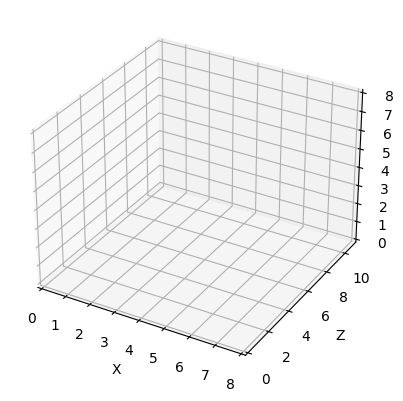

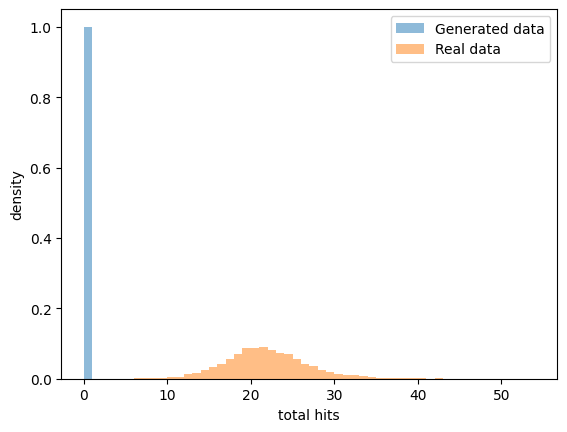

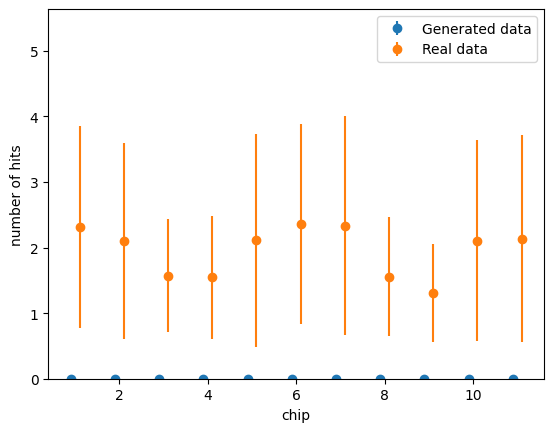

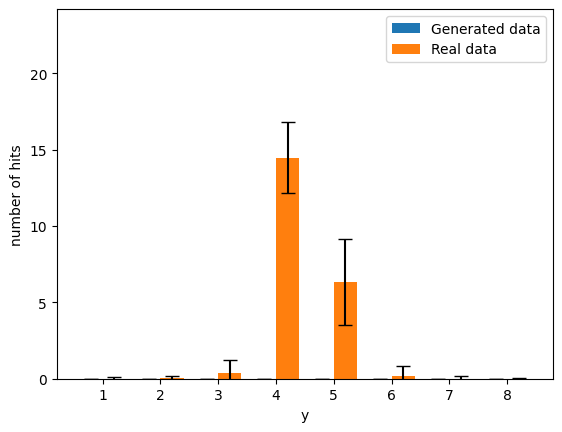

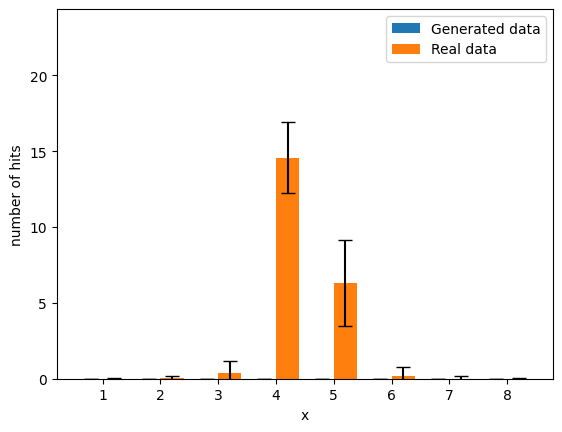

Comparison plots for epoch 0
False


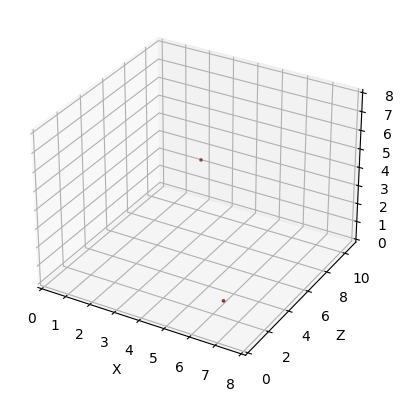

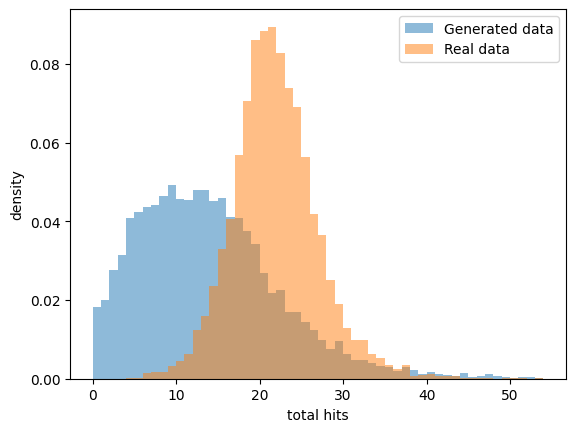

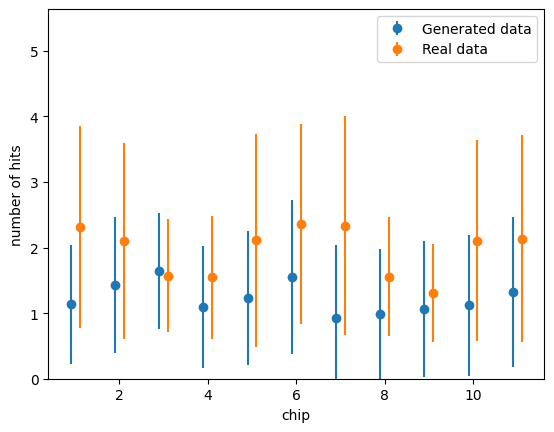

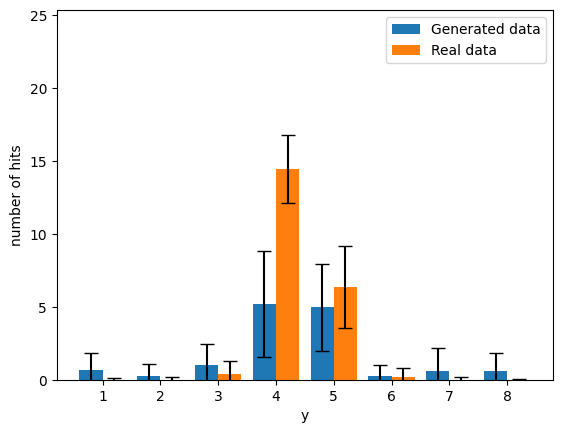

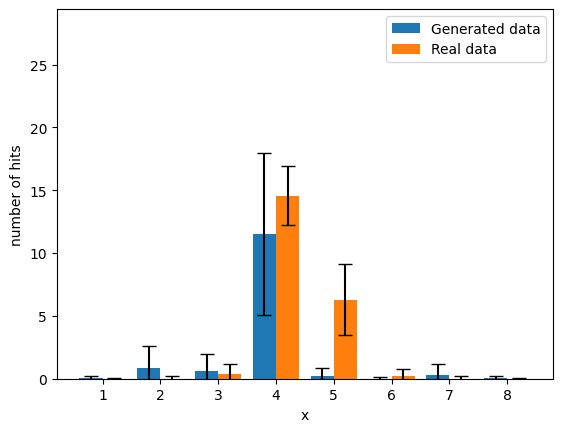

Comparison plots for epoch 5
False


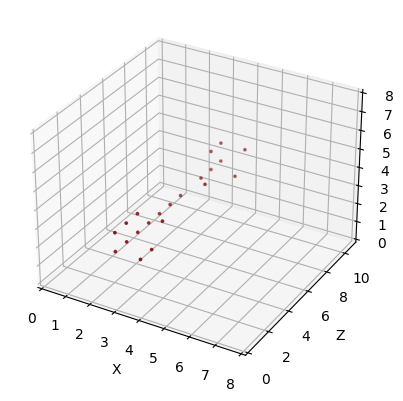

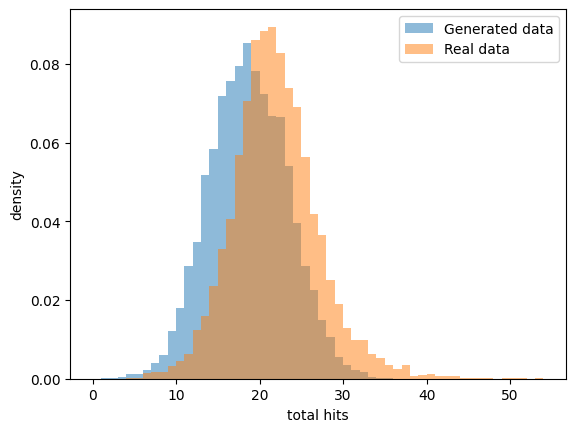

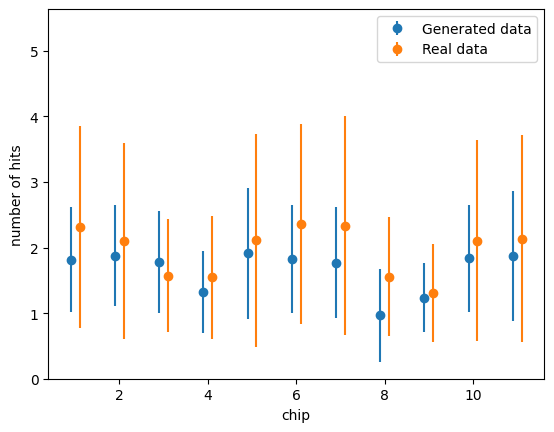

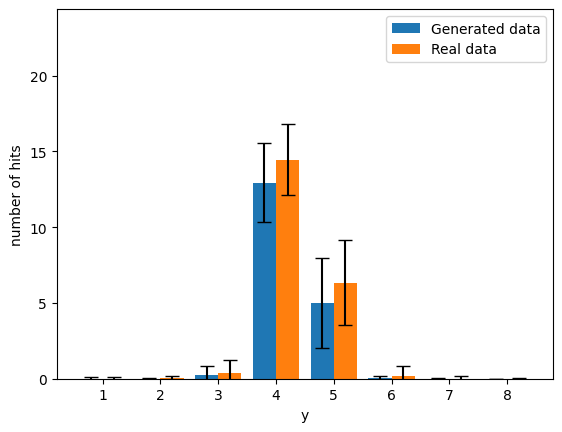

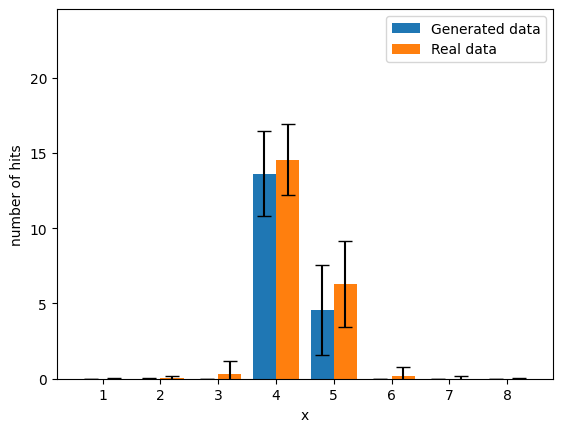

Comparison plots for epoch 10
False


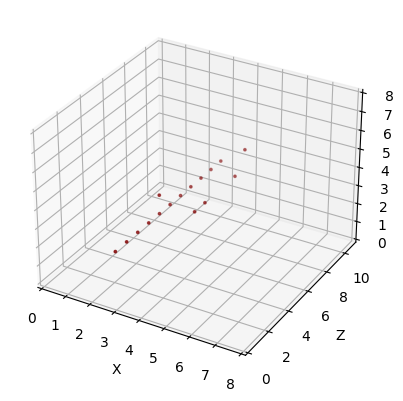

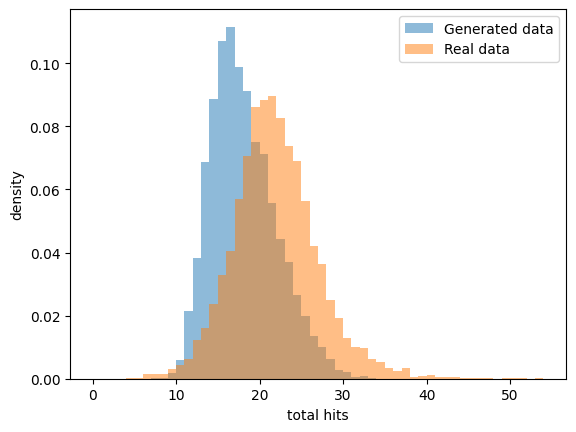

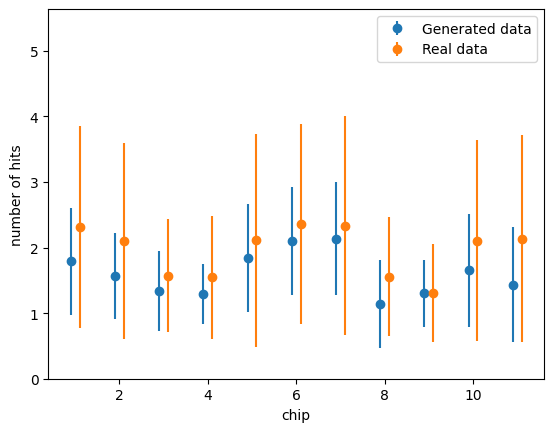

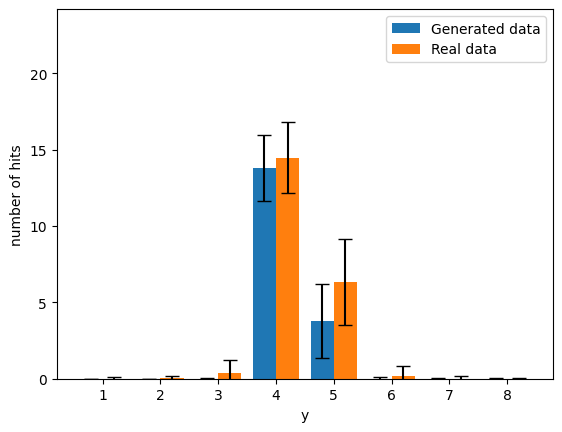

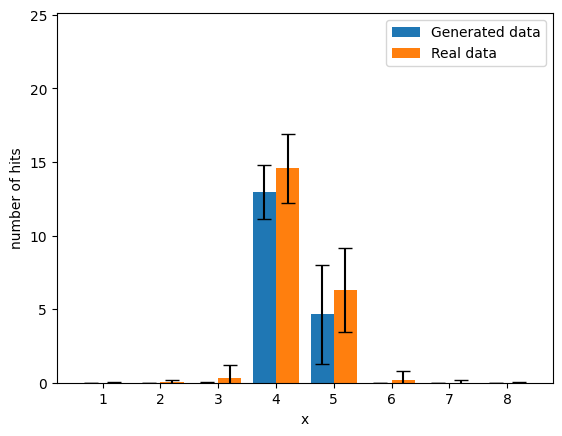

Comparison plots for epoch 15
False


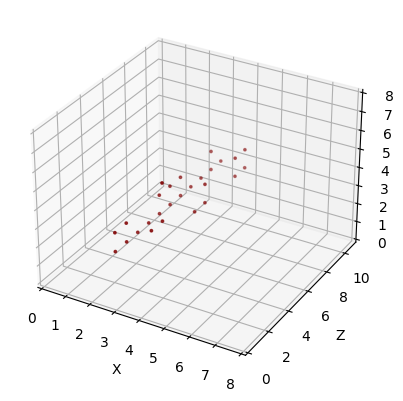

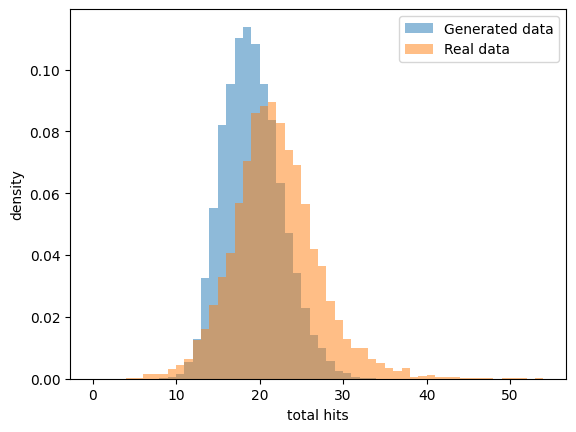

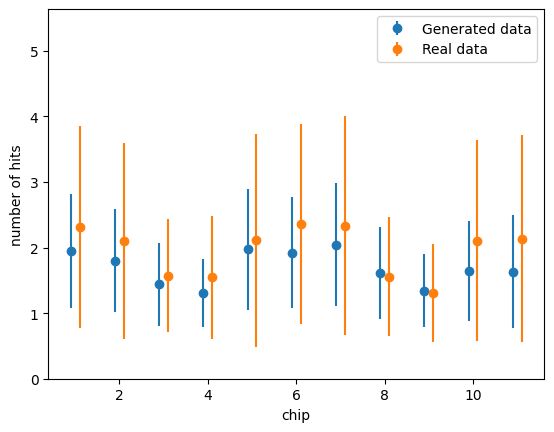

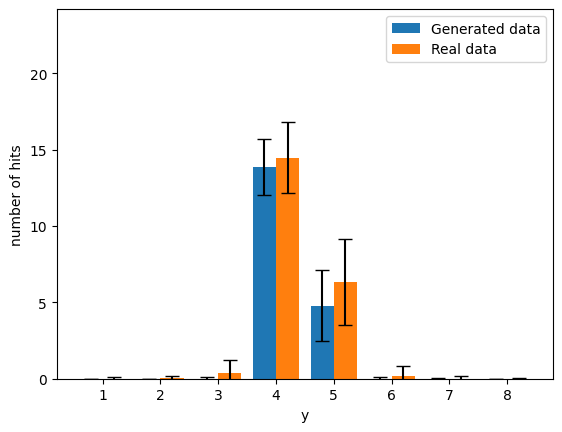

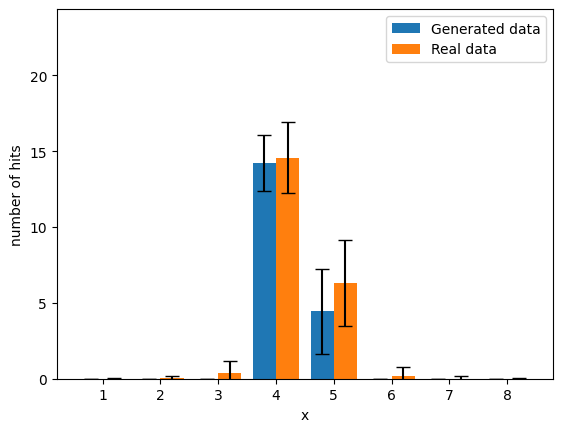

Comparison plots for epoch 20
False


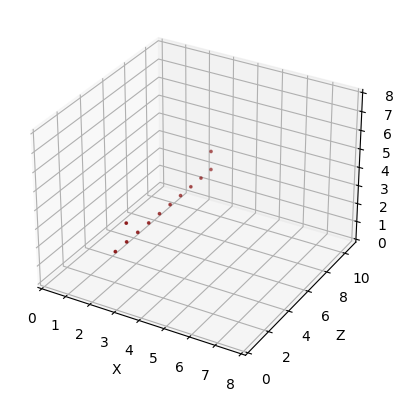

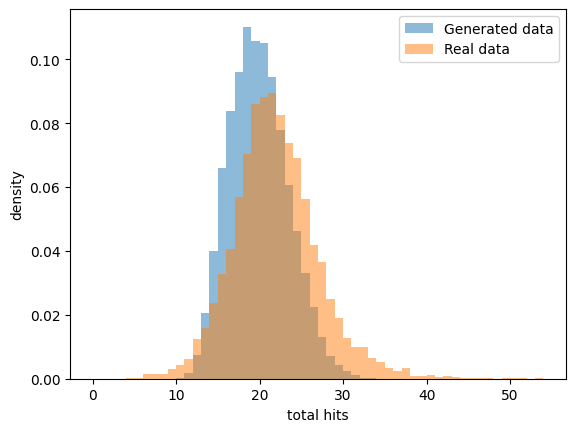

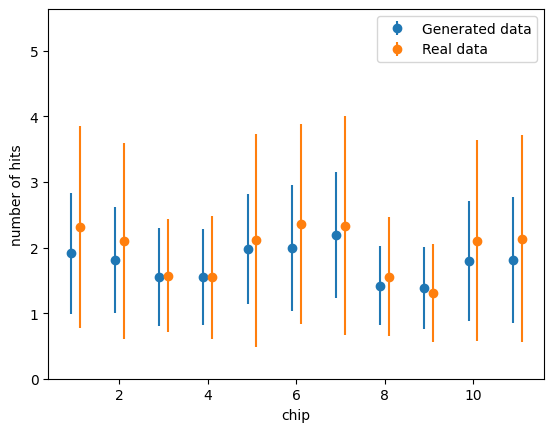

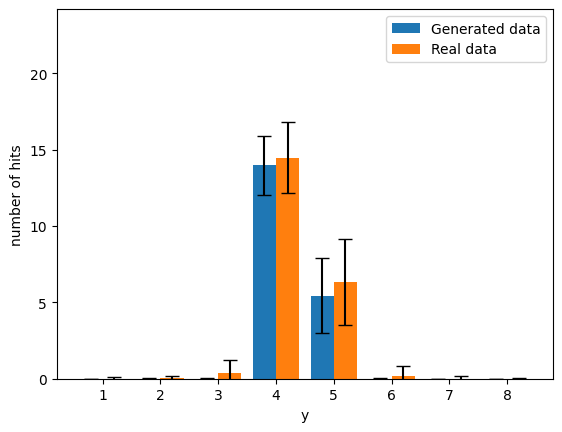

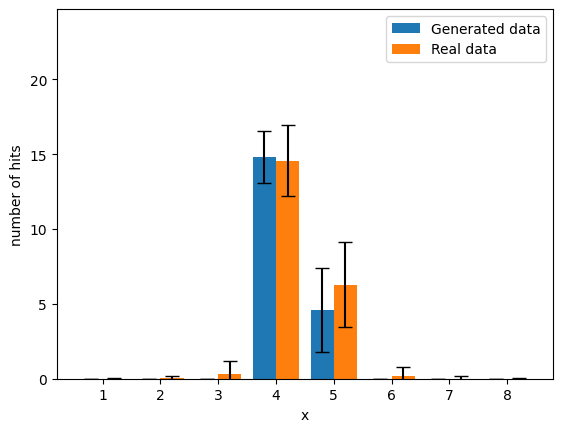

Comparison plots for epoch 25
False


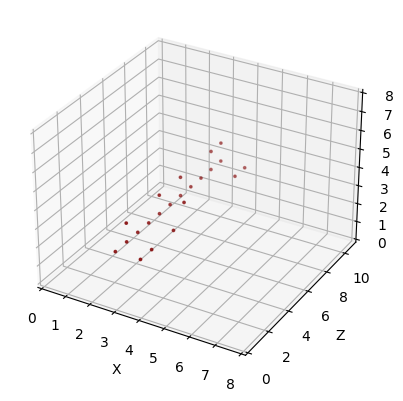

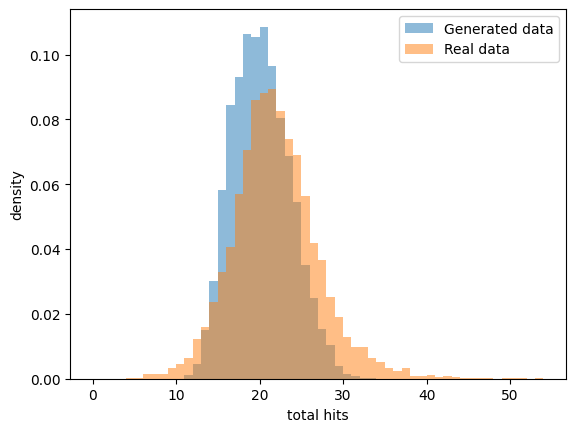

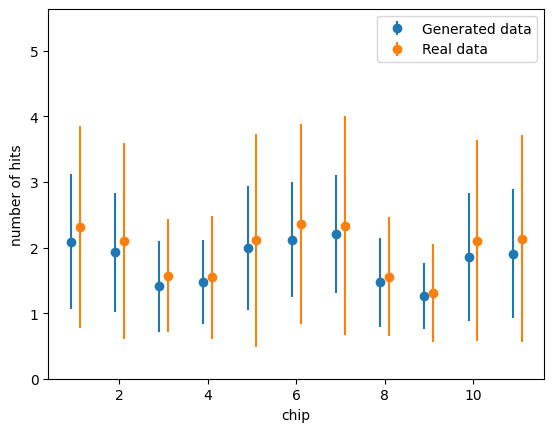

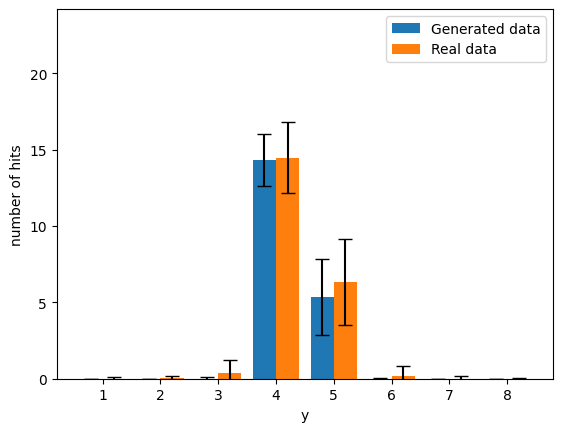

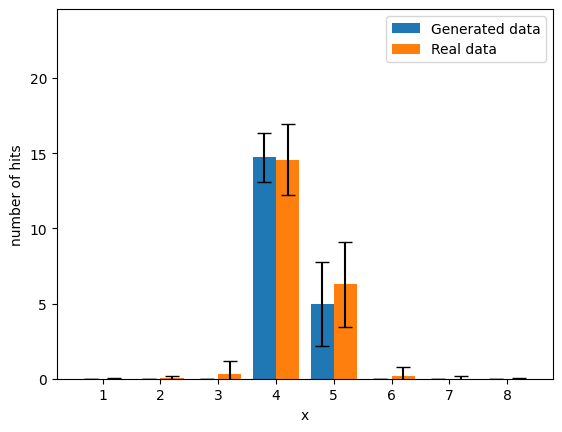

Comparison plots for epoch 30
False


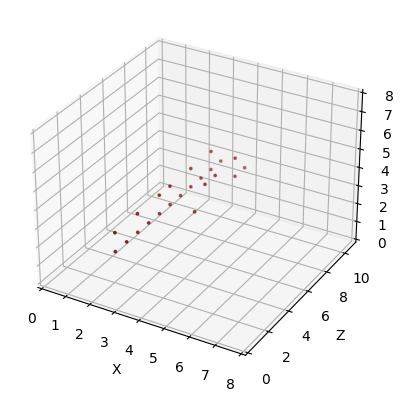

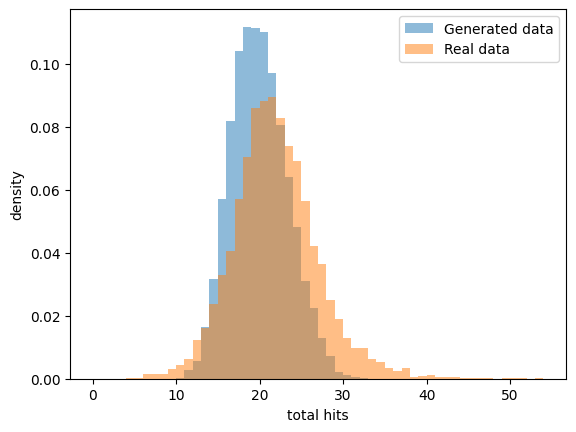

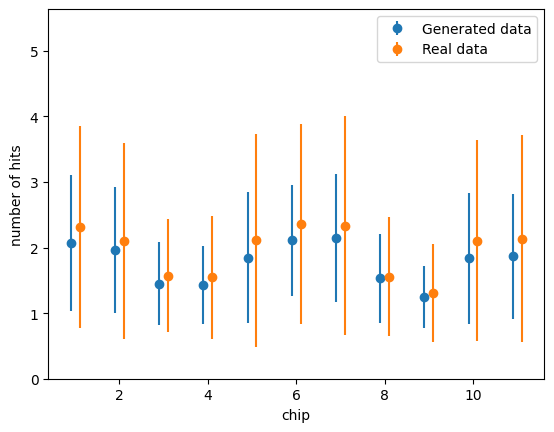

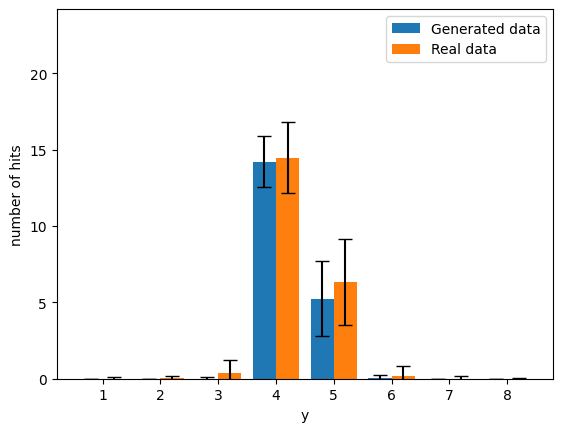

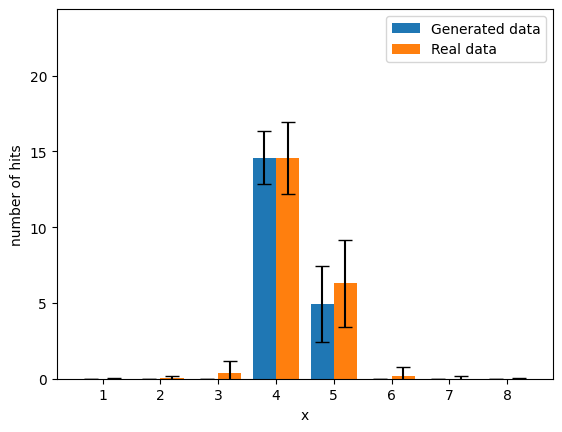

Comparison plots for epoch 35
False


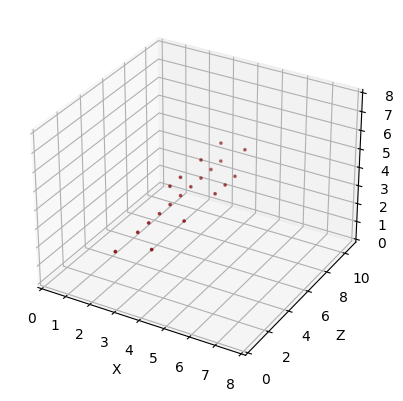

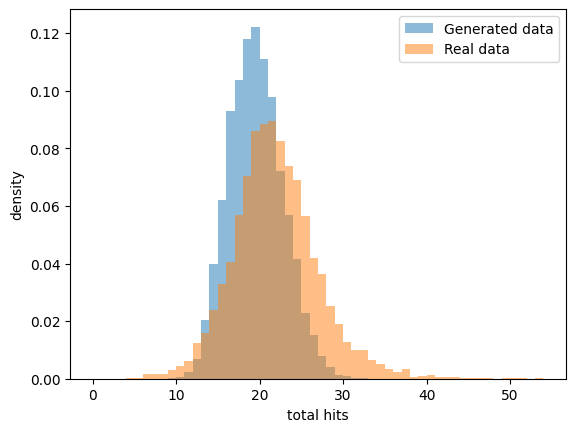

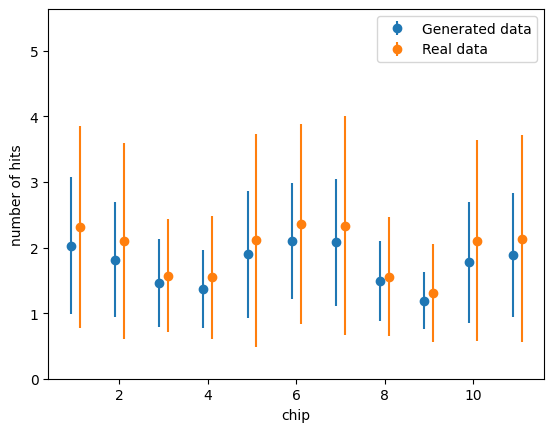

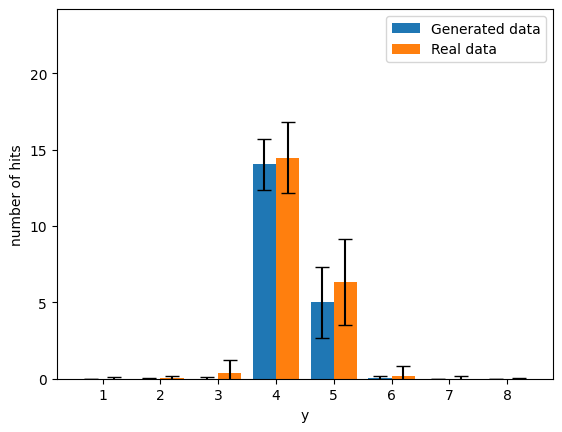

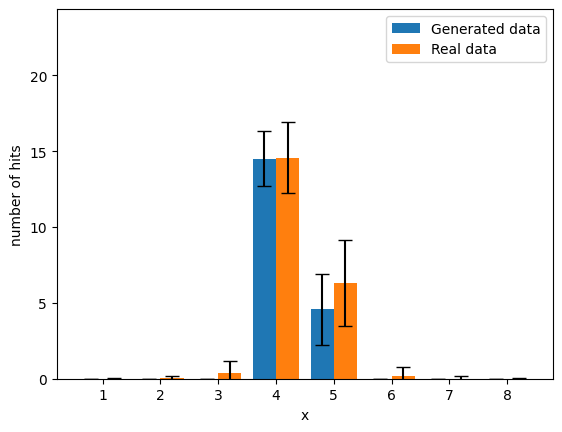

Comparison plots for epoch 40
False


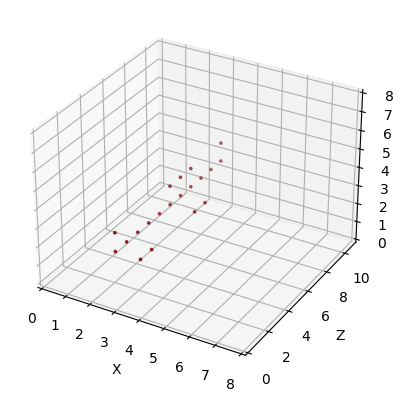

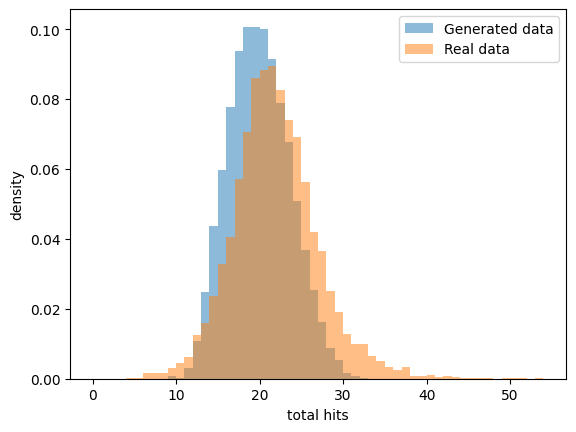

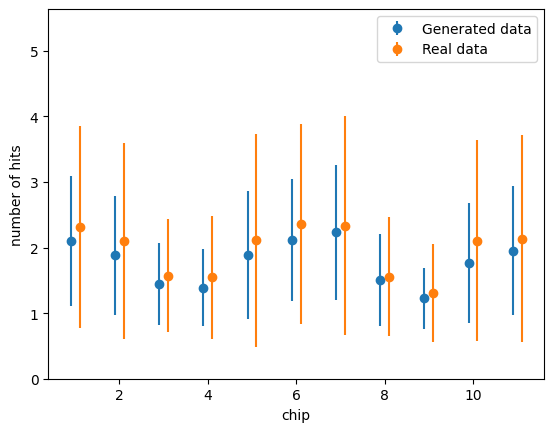

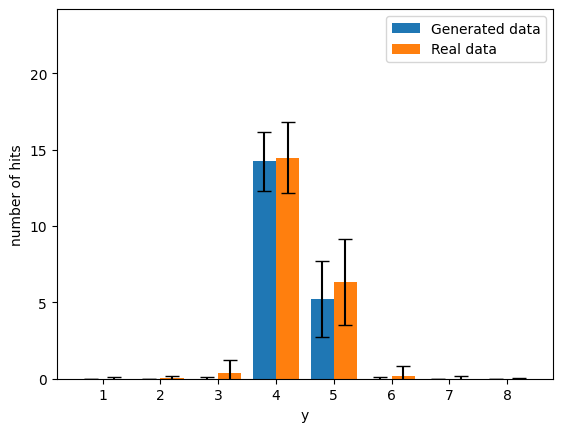

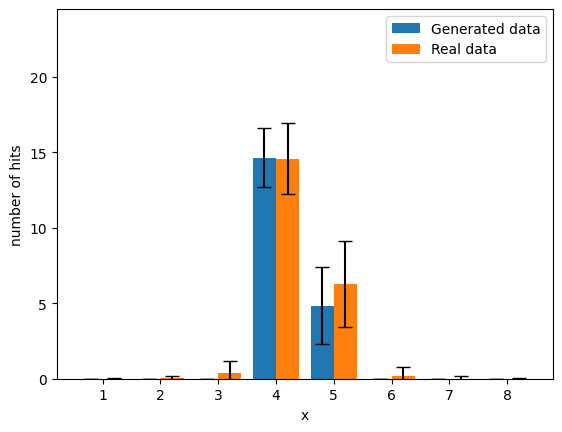

Comparison plots for epoch 45
False


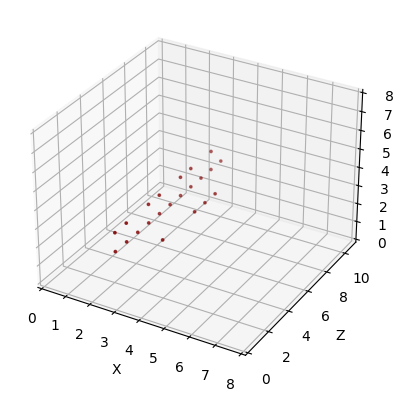

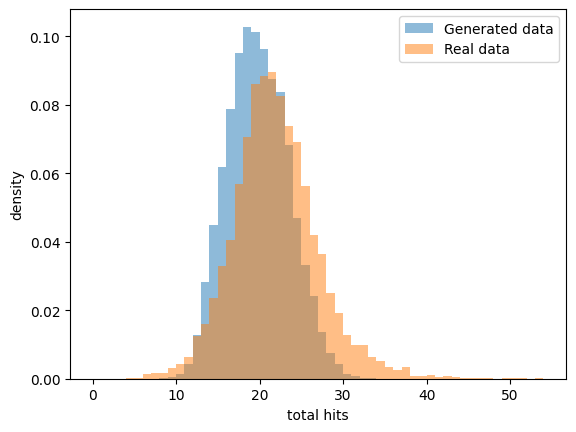

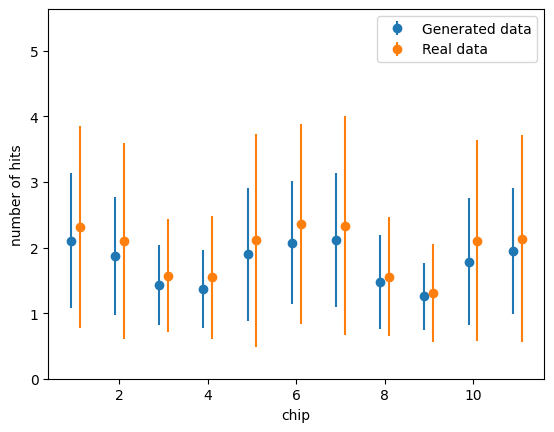

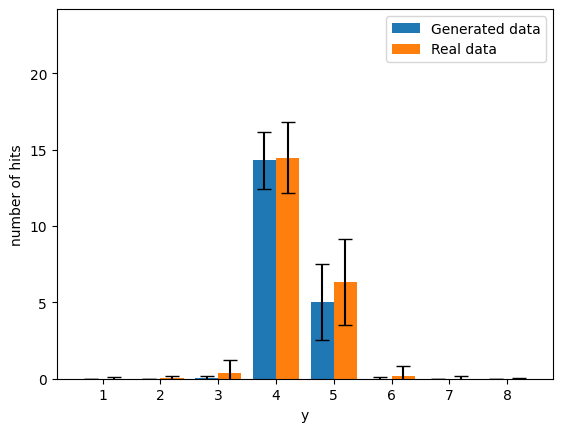

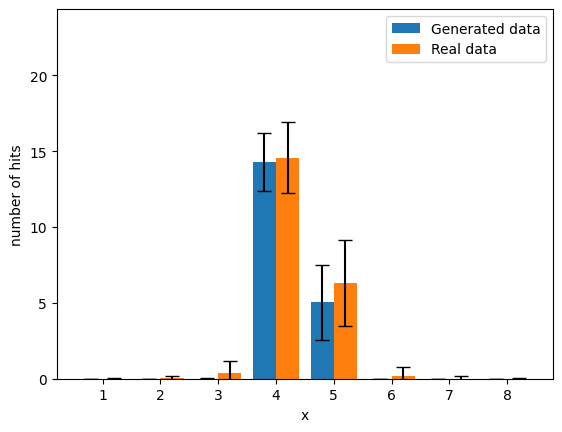

Comparison plots for epoch 50
False


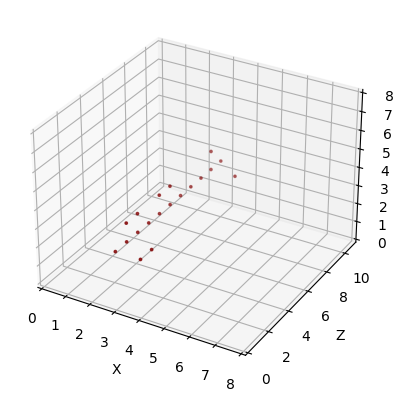

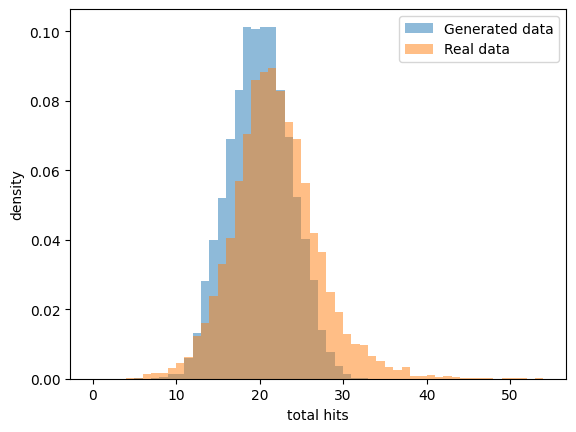

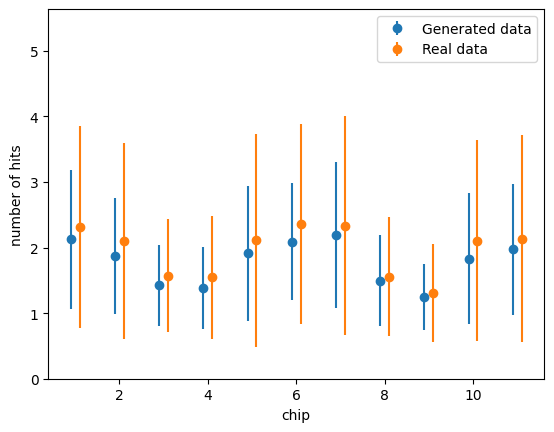

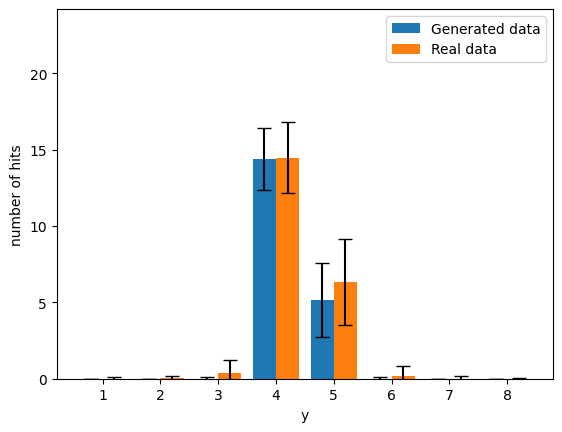

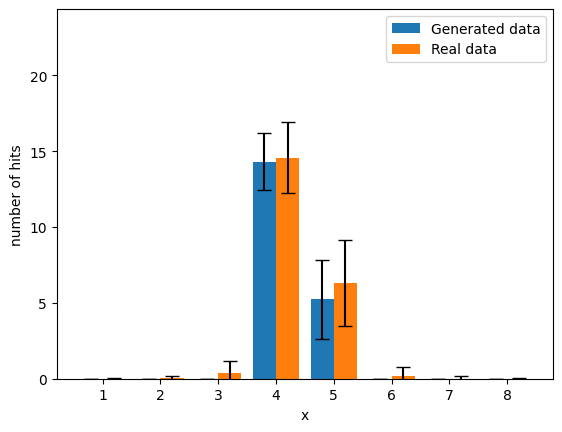

Comparison plots for epoch 55
False


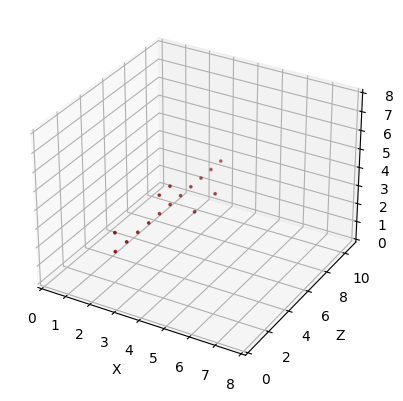

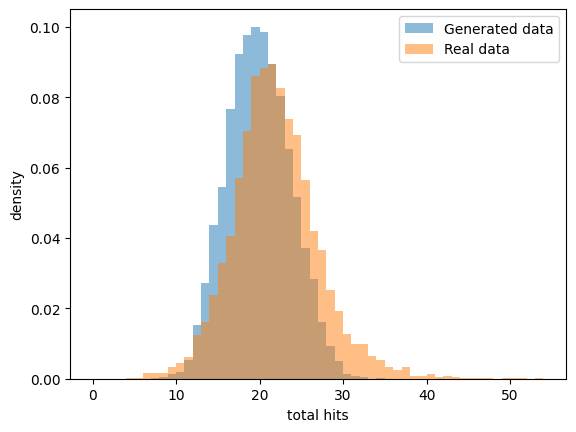

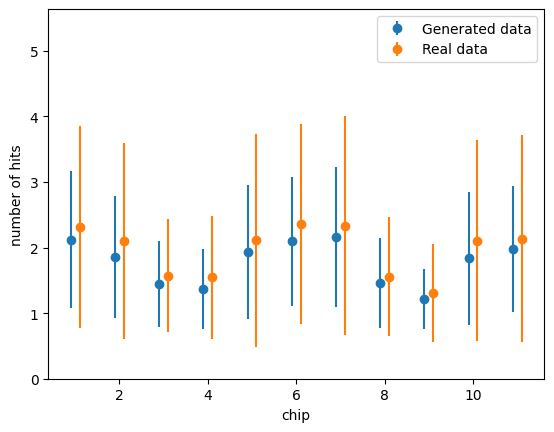

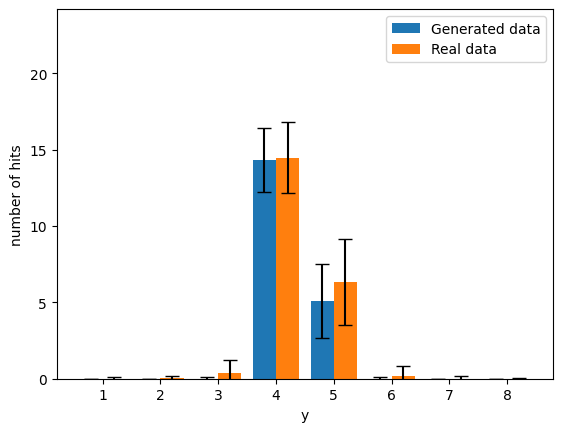

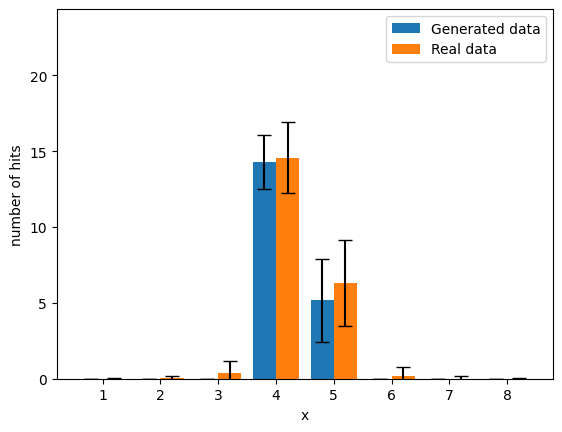

Comparison plots for epoch 60
False


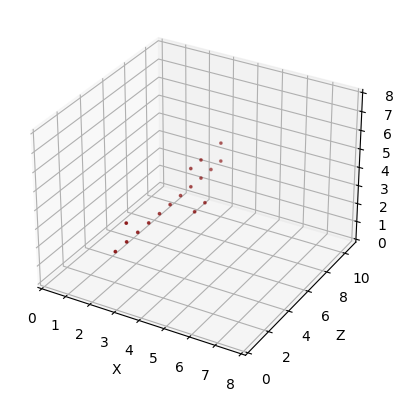

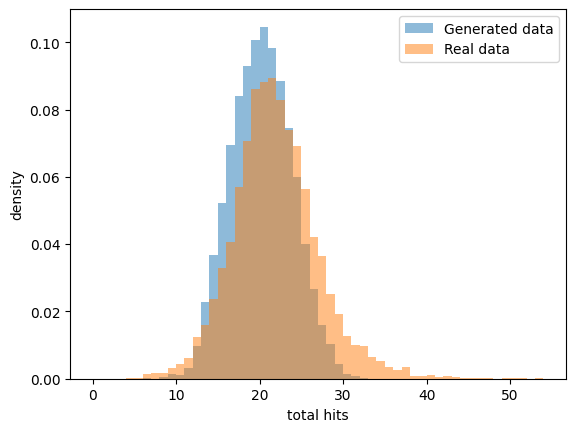

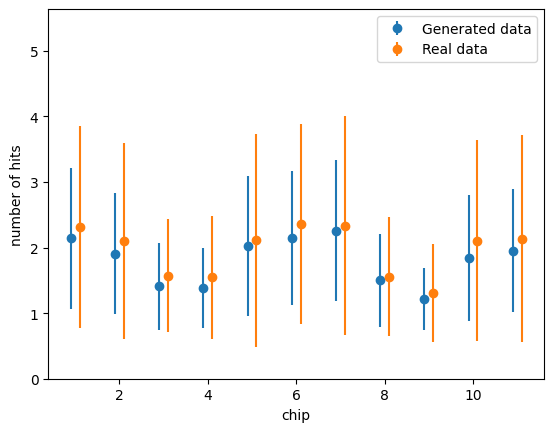

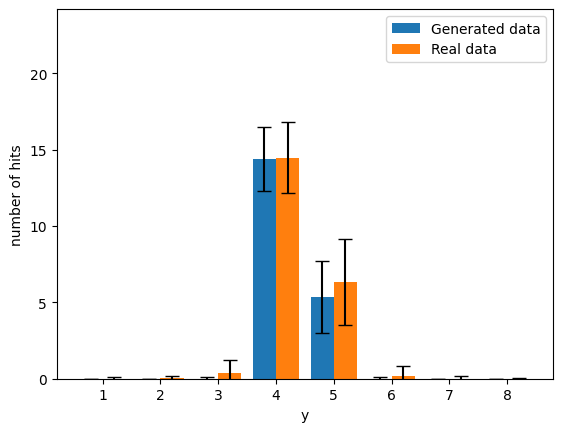

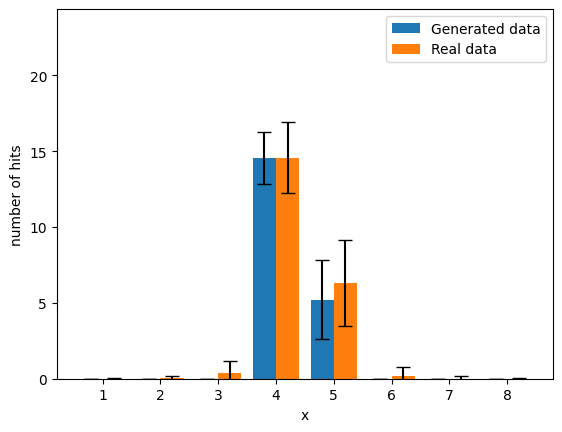

Comparison plots for epoch 65
False


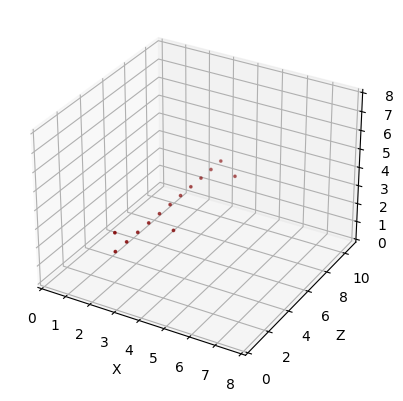

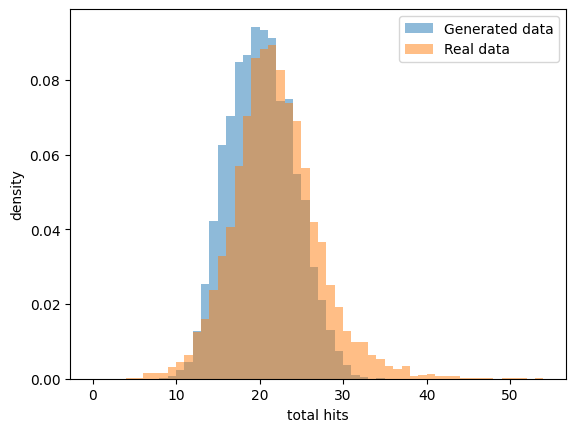

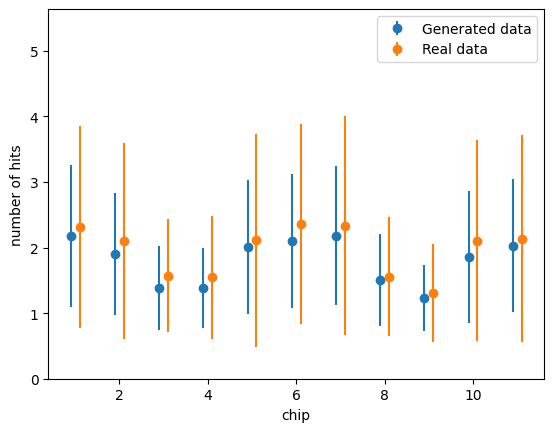

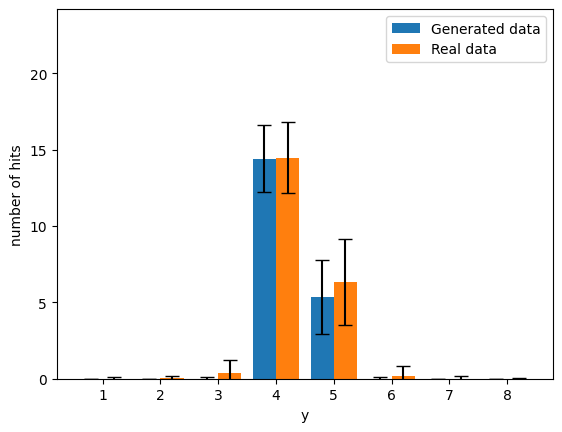

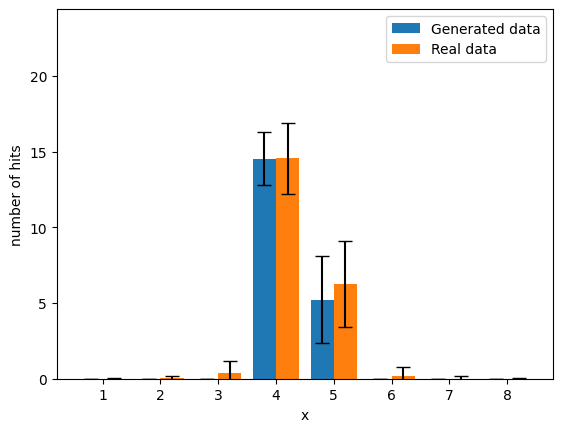

Comparison plots for epoch 70
False


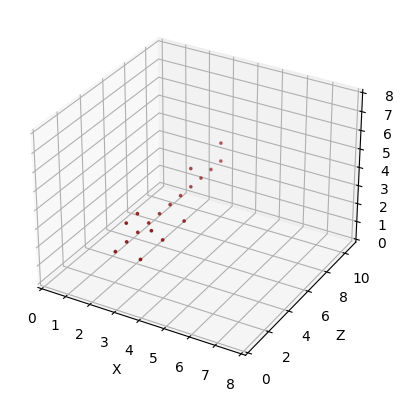

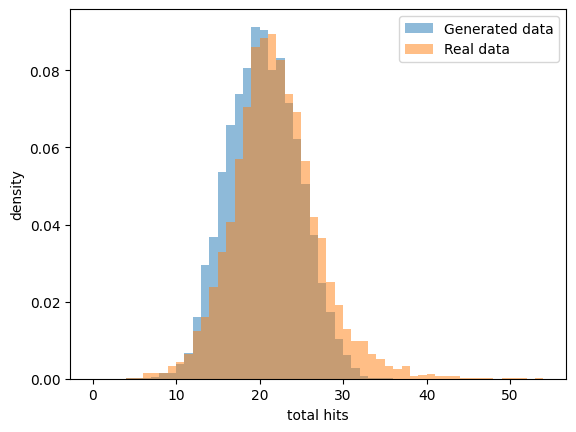

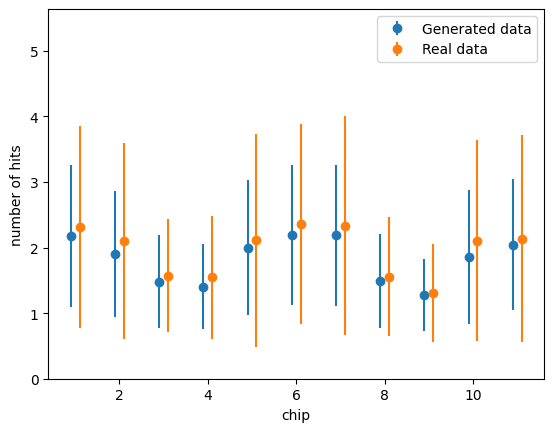

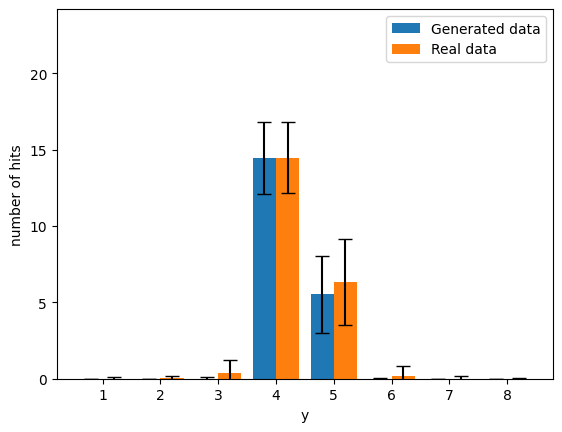

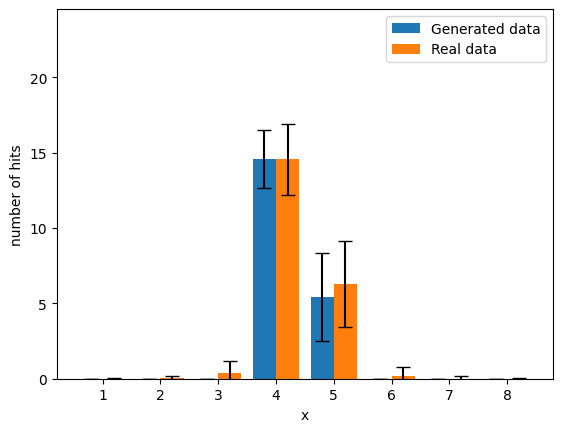

Comparison plots for epoch 75
False


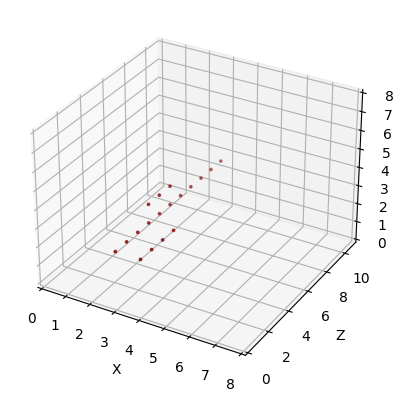

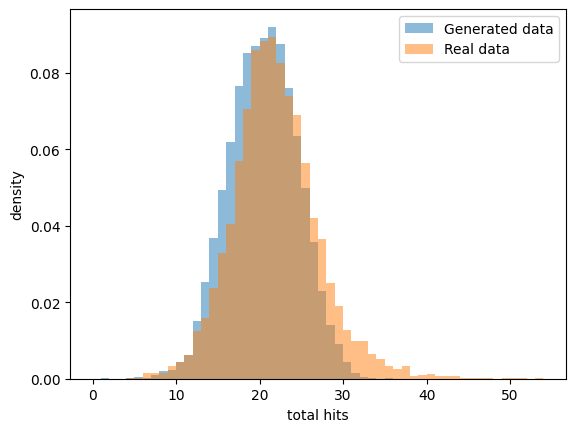

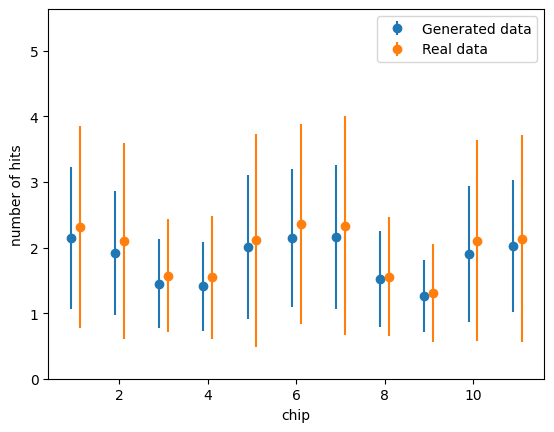

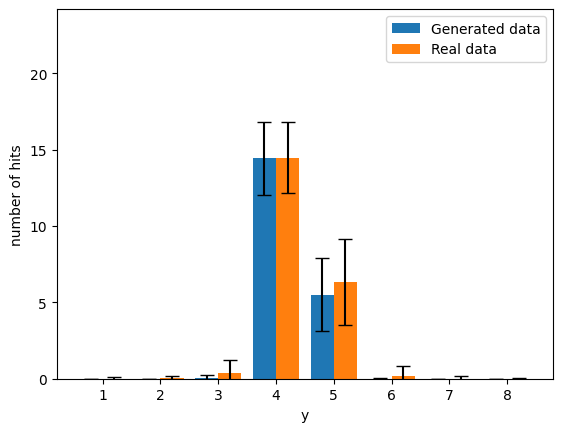

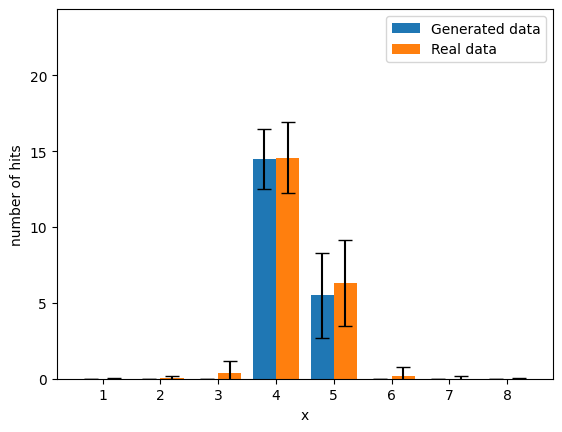

Comparison plots for epoch 80
False


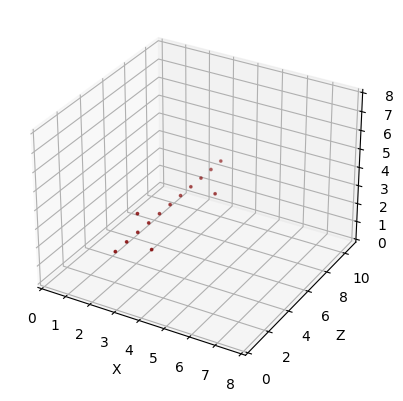

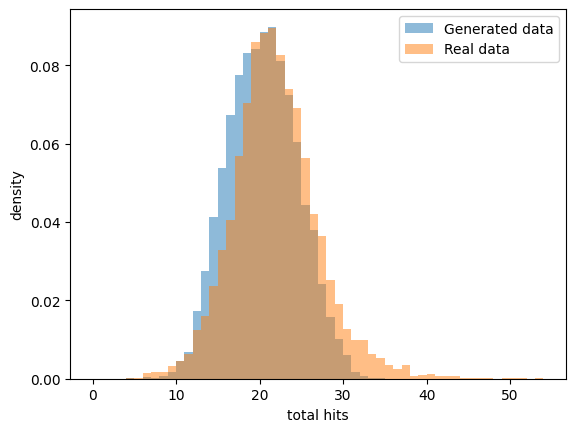

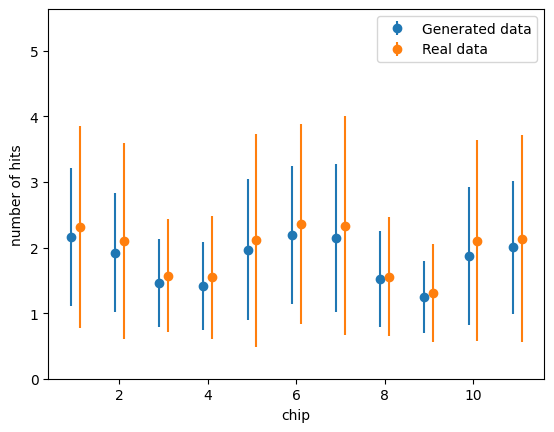

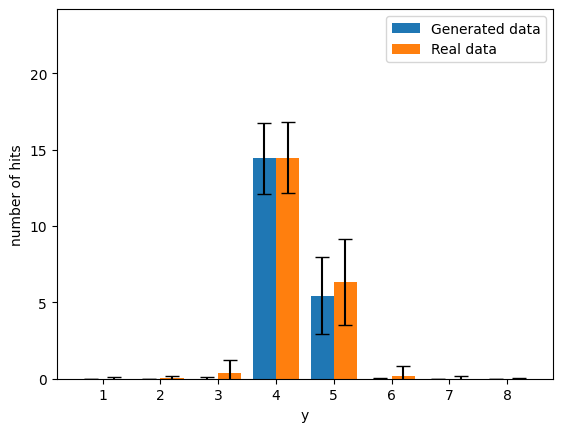

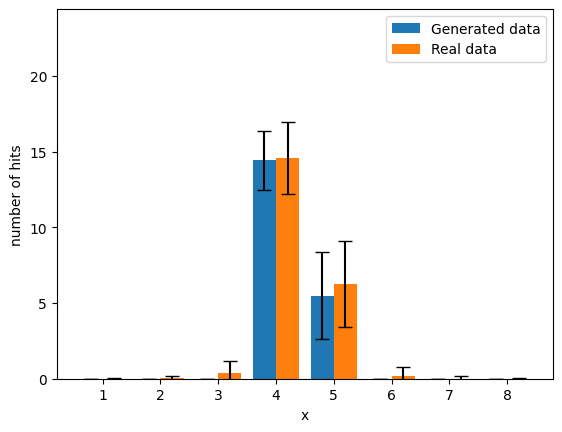

Comparison plots for epoch 85
False


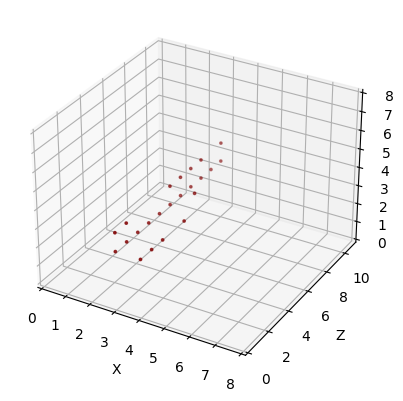

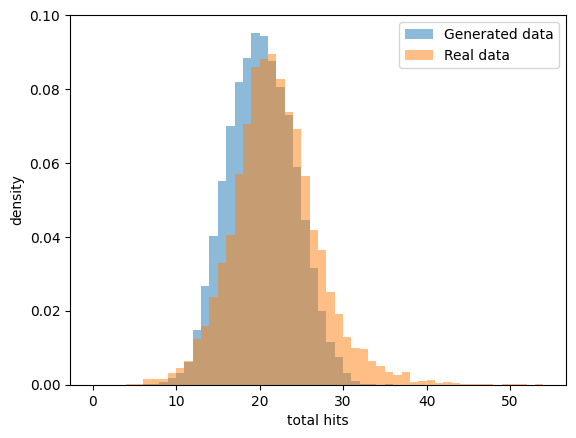

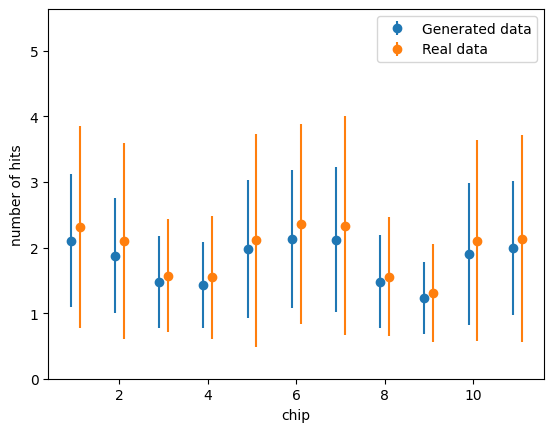

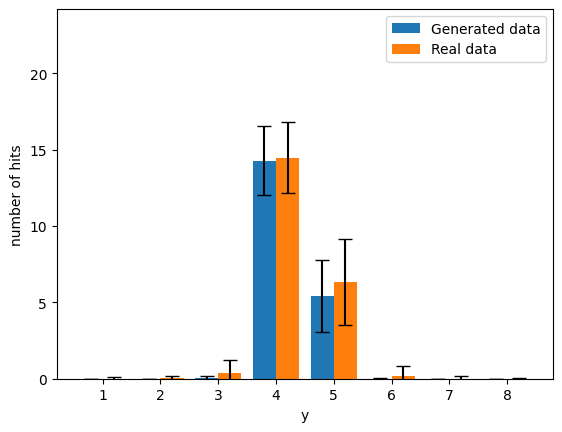

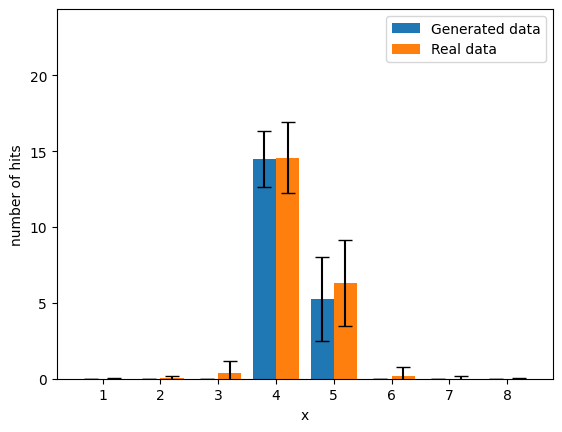

Comparison plots for epoch 90
False


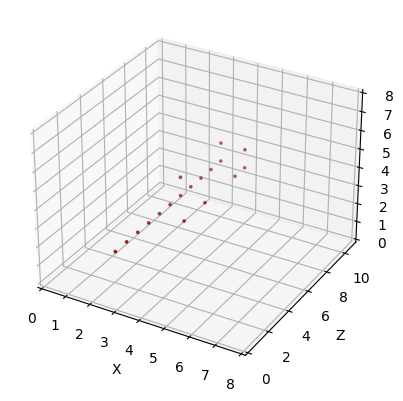

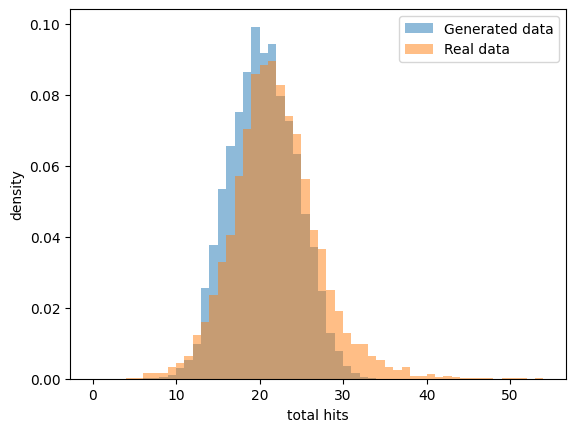

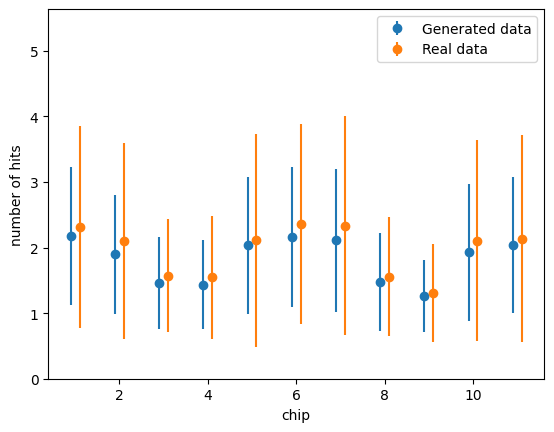

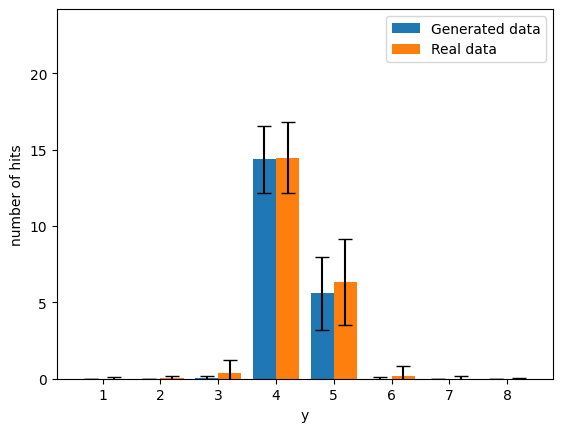

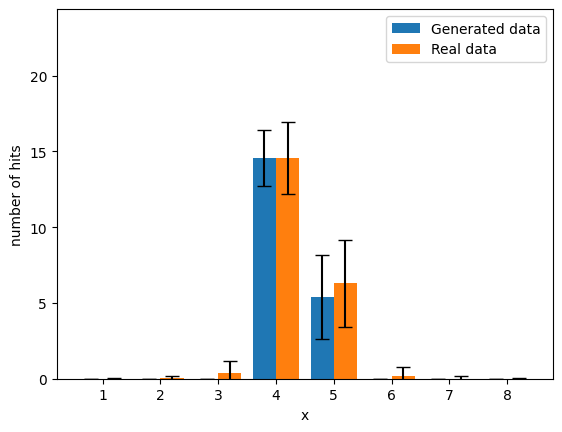

Comparison plots for epoch 95
False


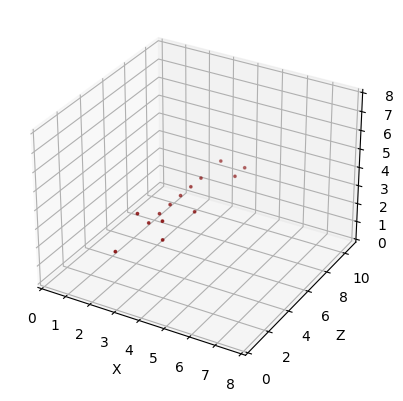

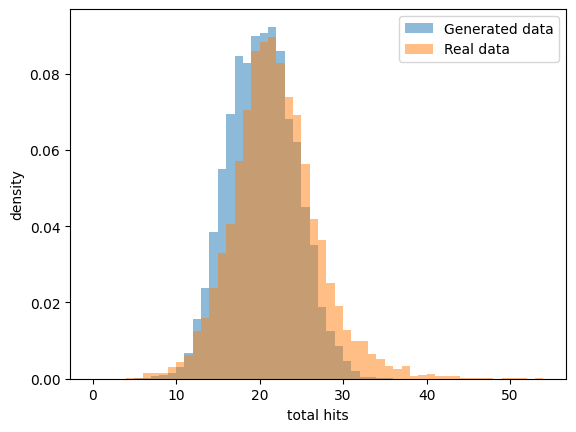

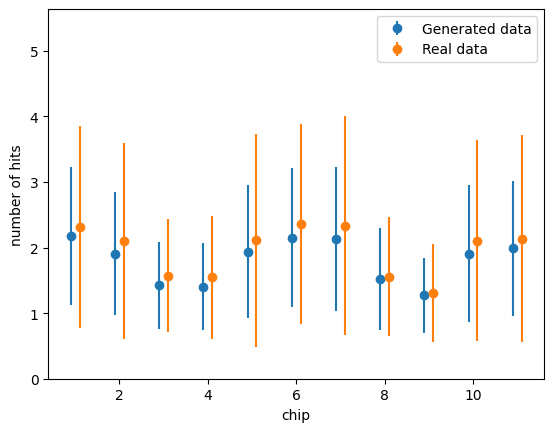

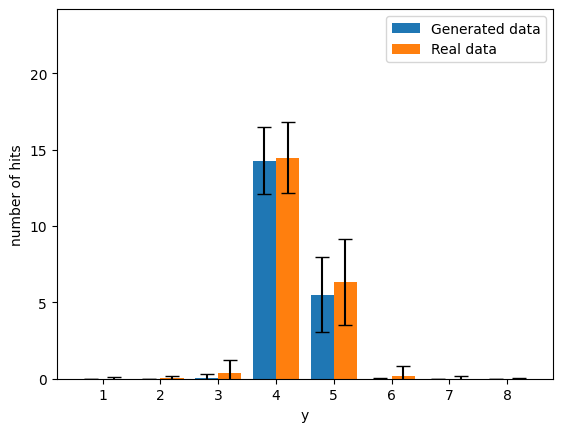

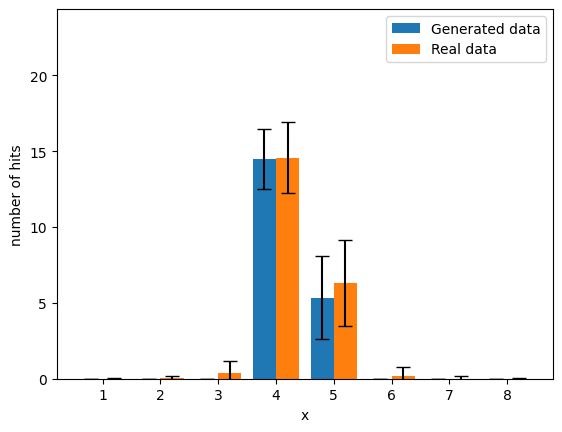

Comparison plots for epoch 100
False


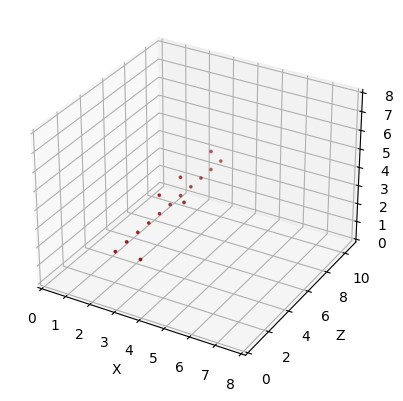

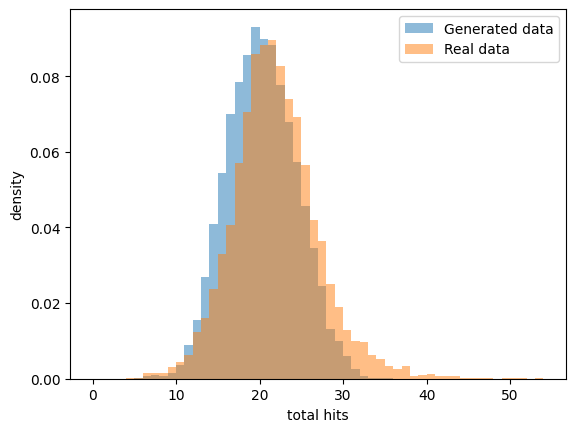

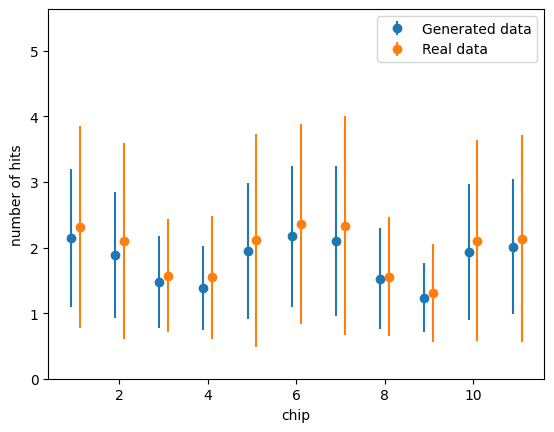

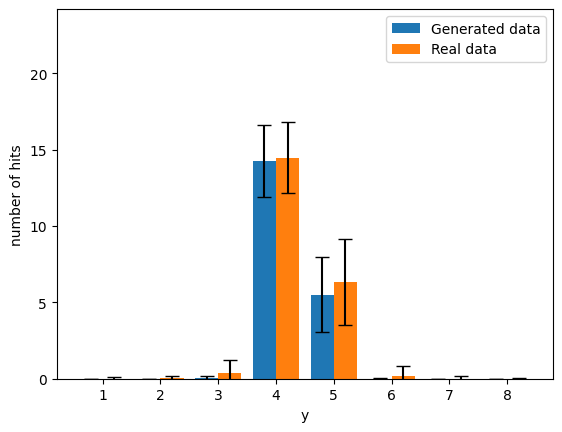

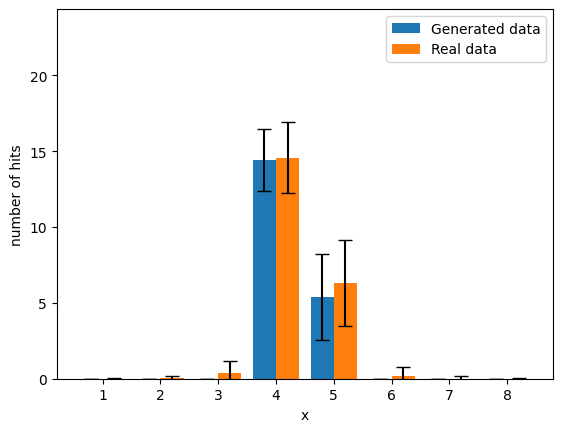

Comparison plots for epoch 105
False


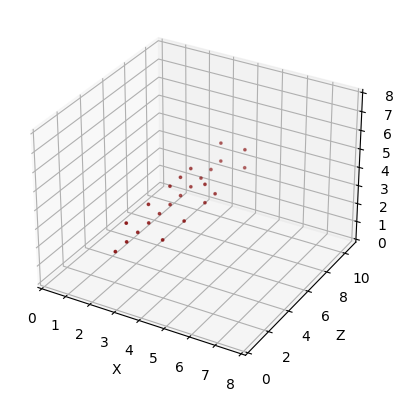

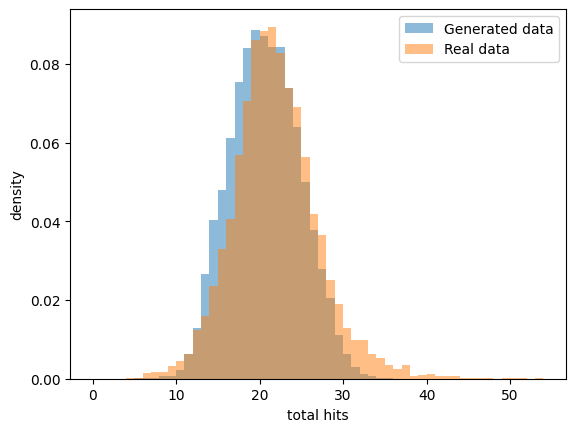

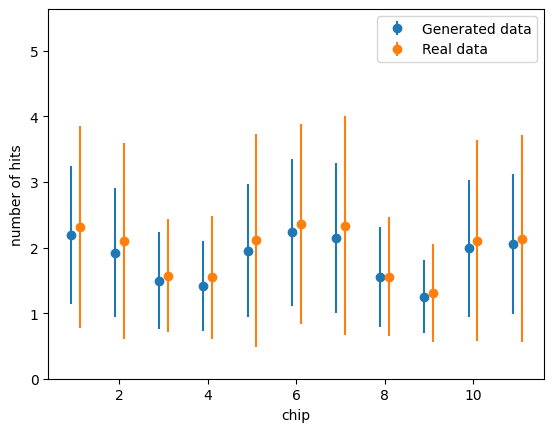

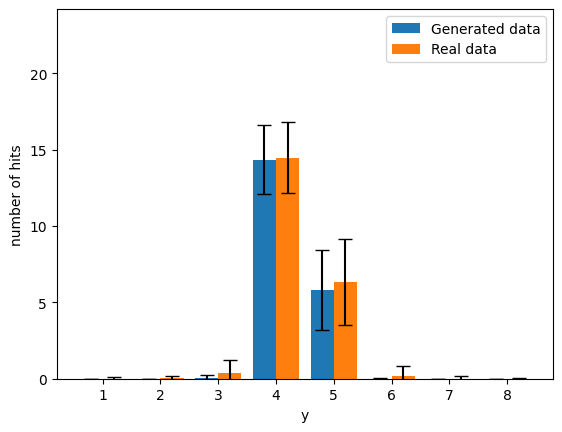

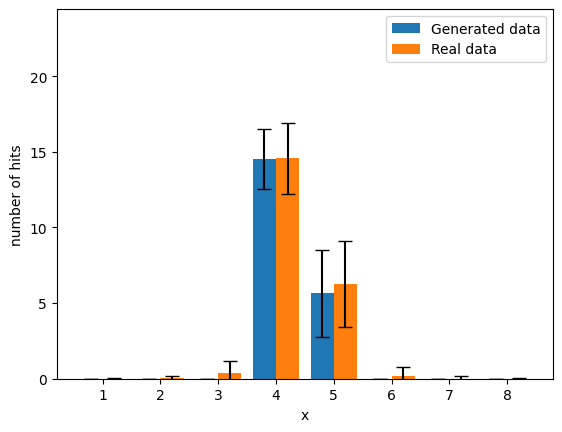

Comparison plots for epoch 110
False


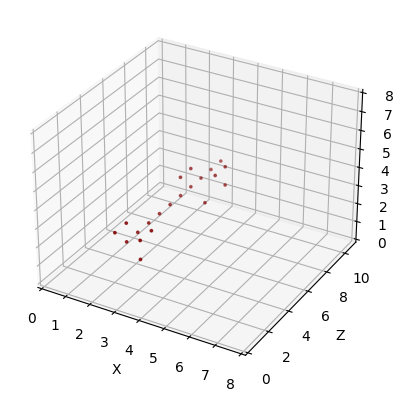

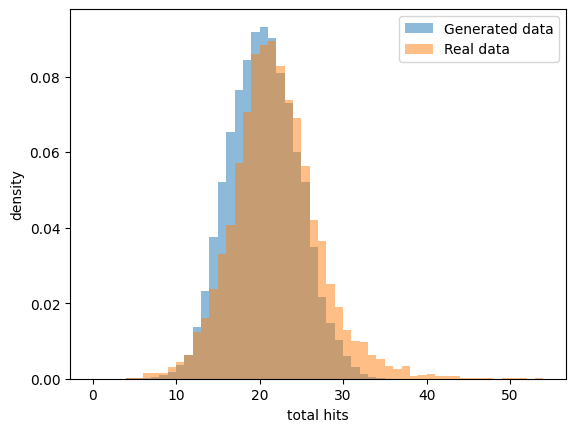

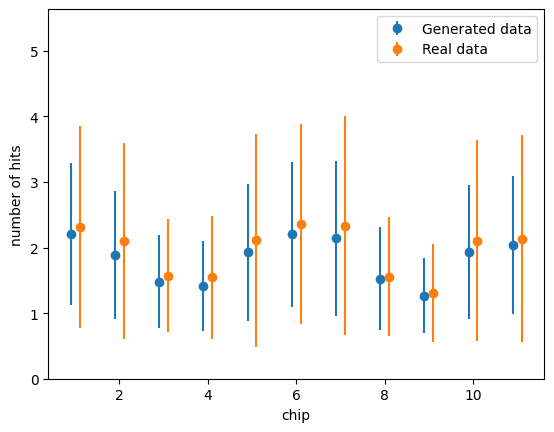

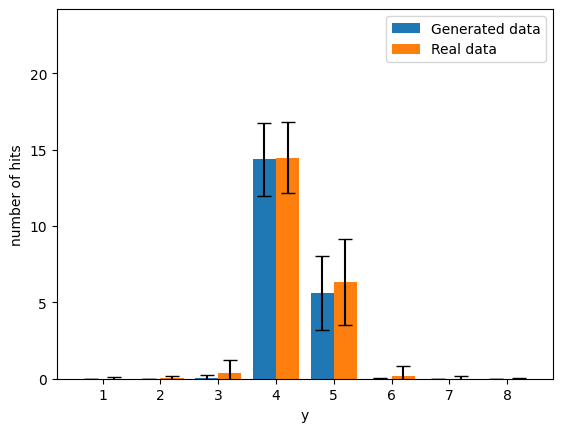

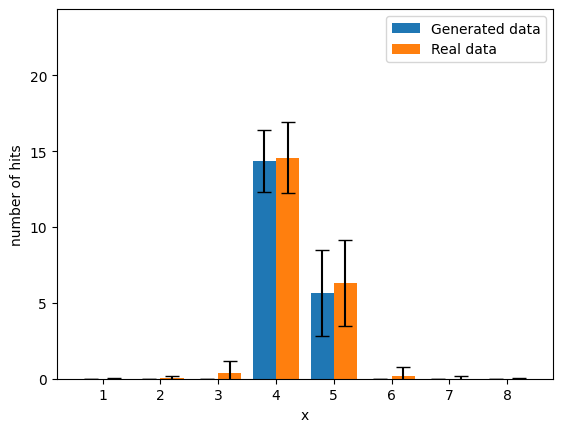

Comparison plots for epoch 115
False


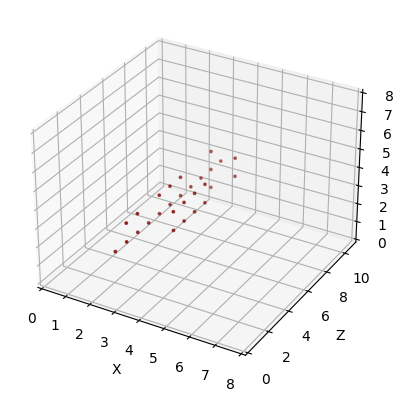

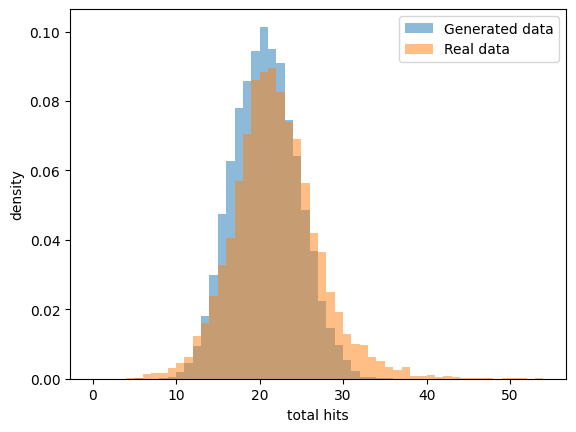

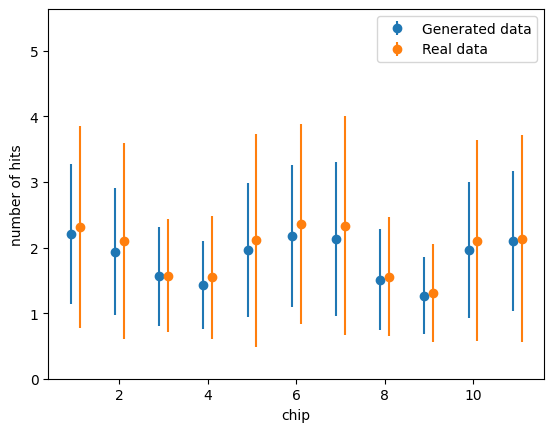

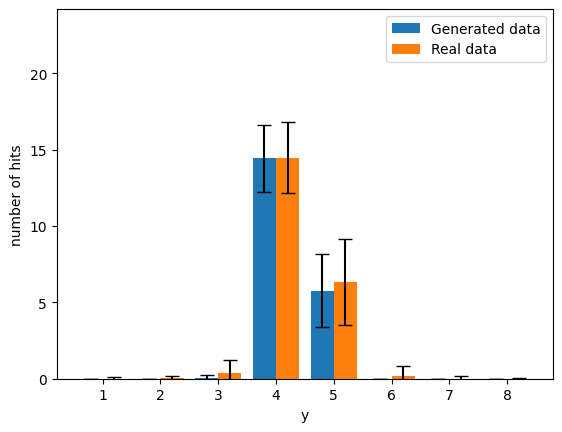

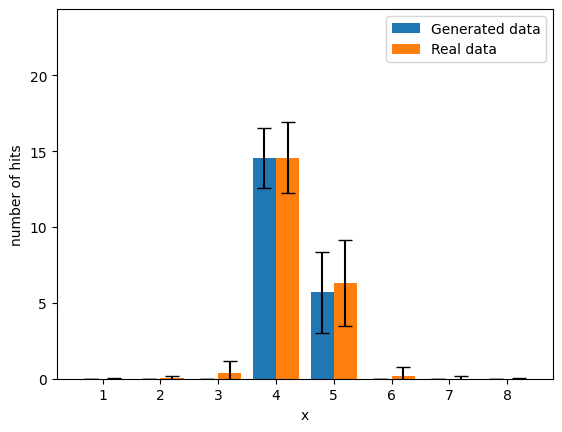

Comparison plots for epoch 120
False


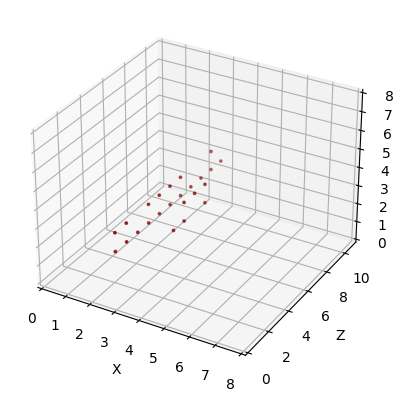

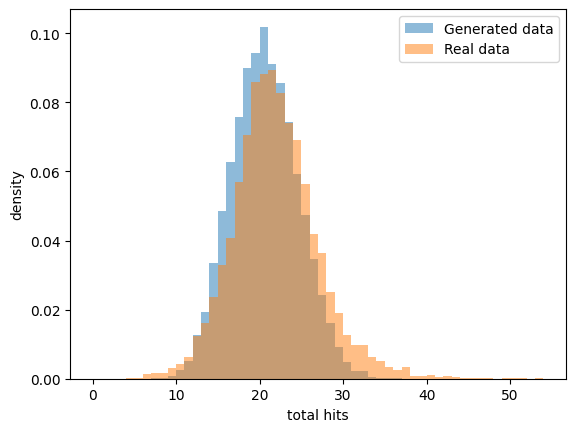

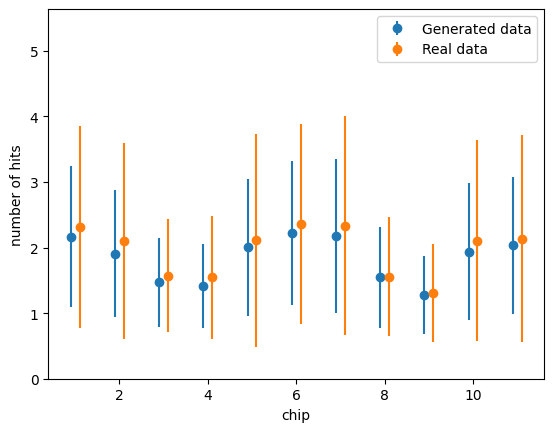

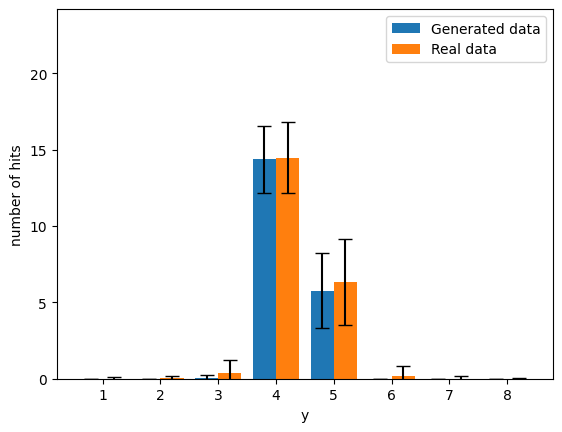

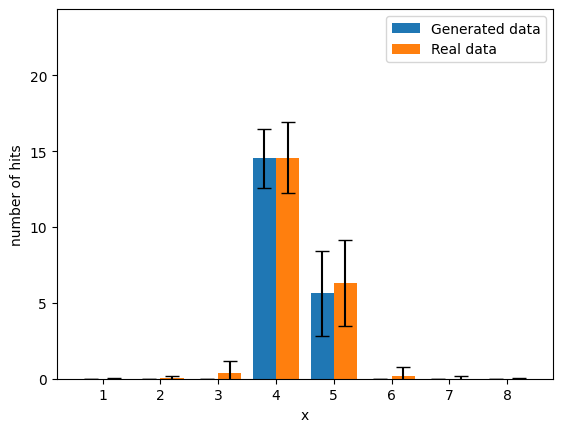

Comparison plots for epoch 125
False


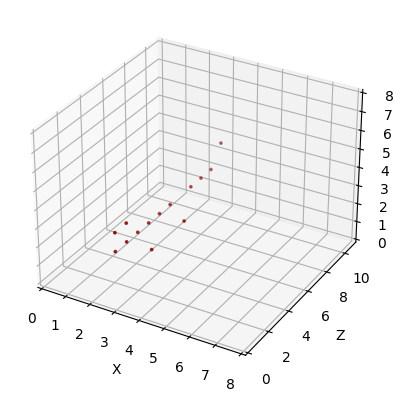

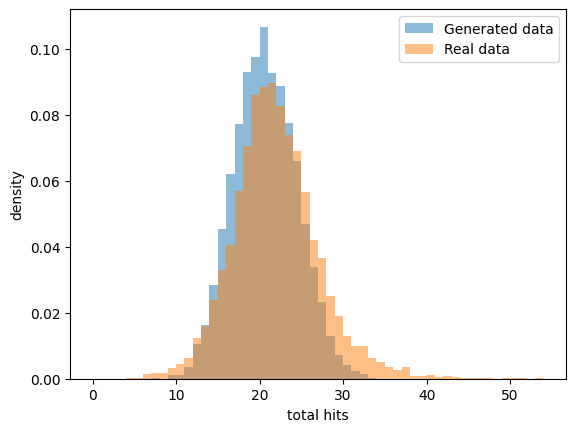

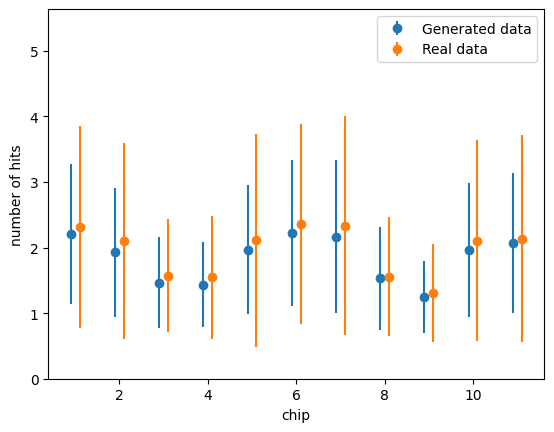

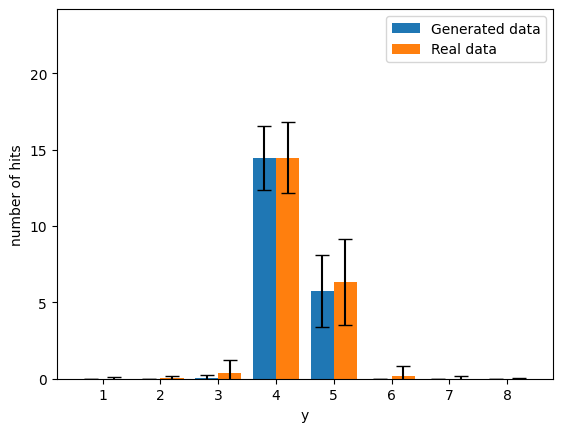

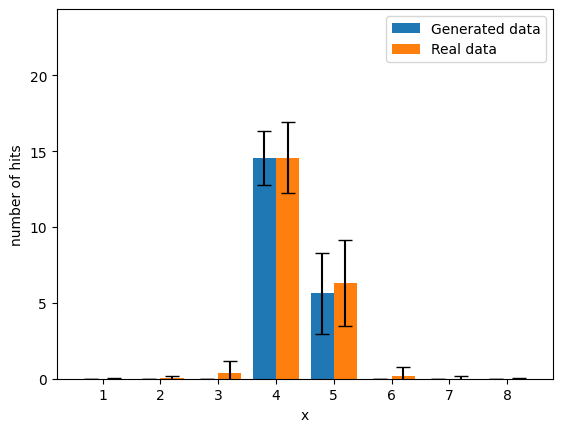

Comparison plots for epoch 130
False


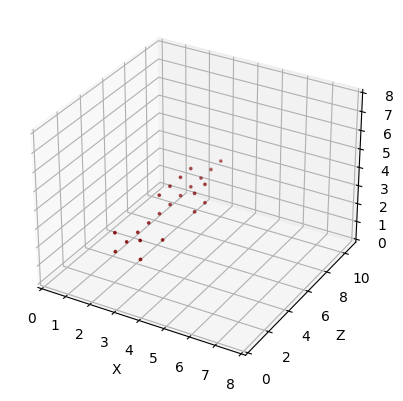

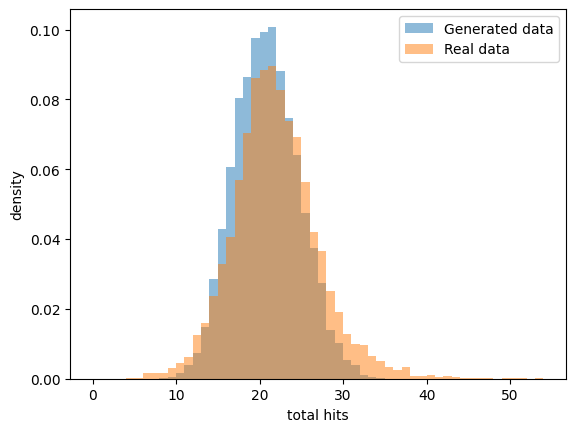

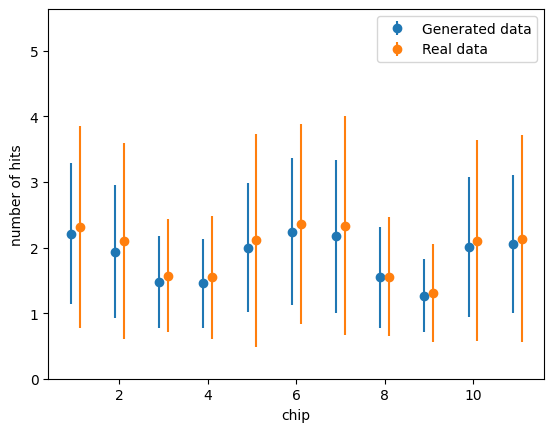

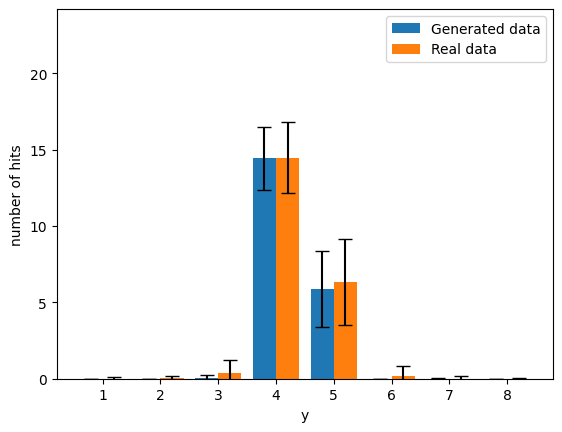

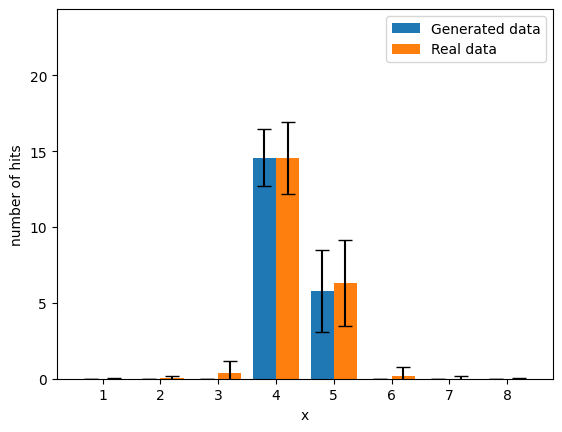

Comparison plots for epoch 135
False


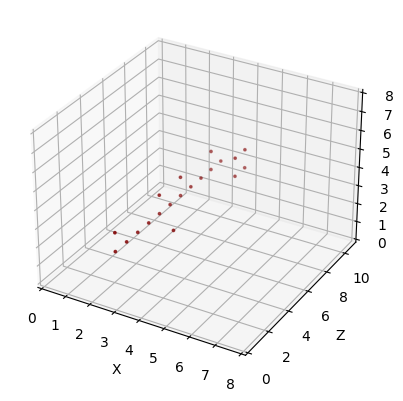

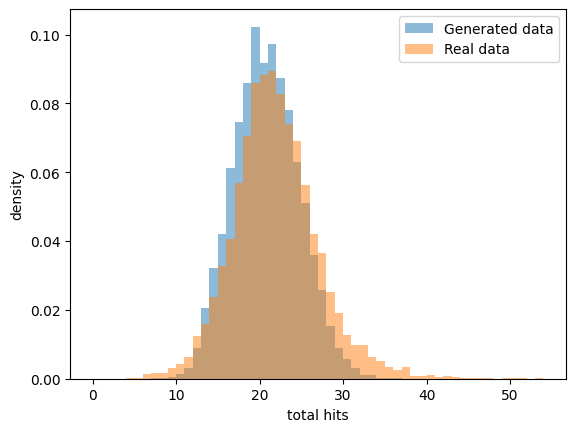

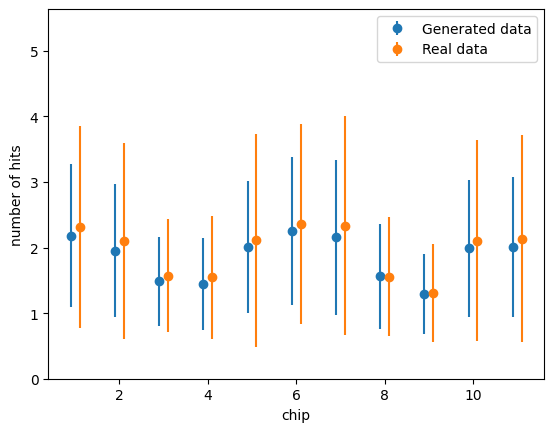

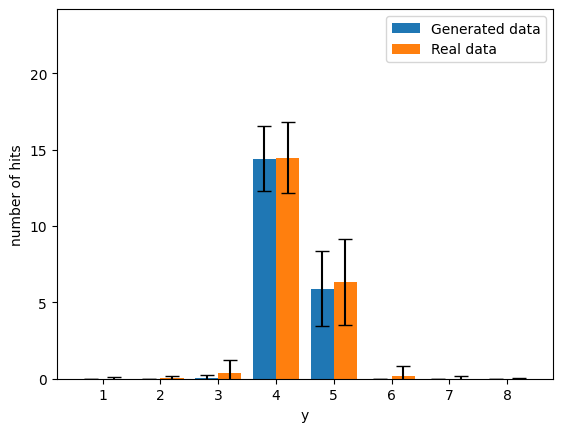

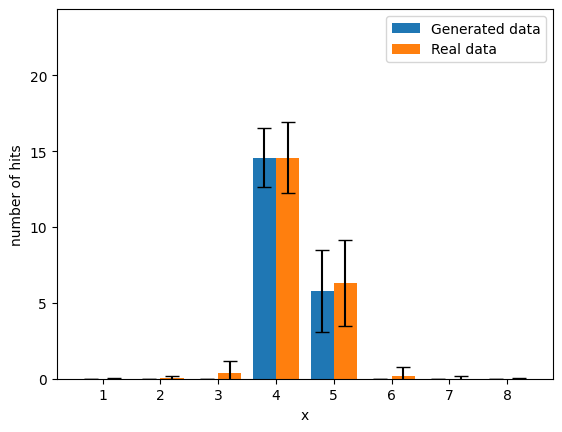

Comparison plots for epoch 140
False


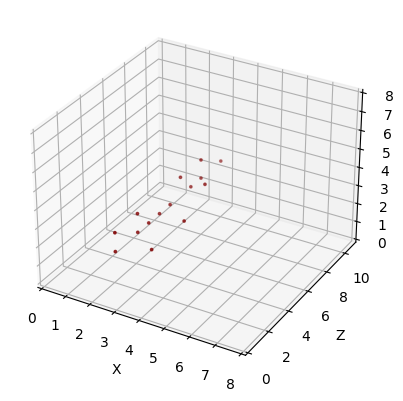

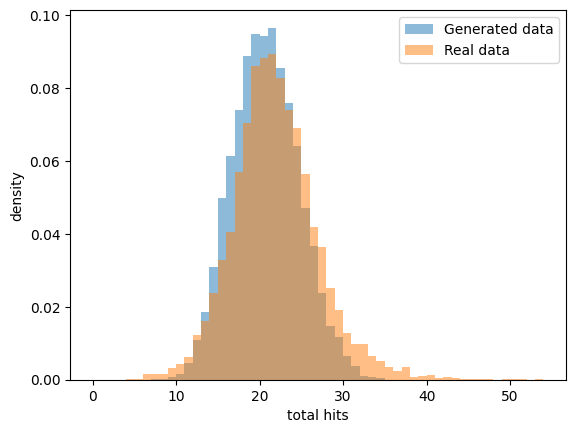

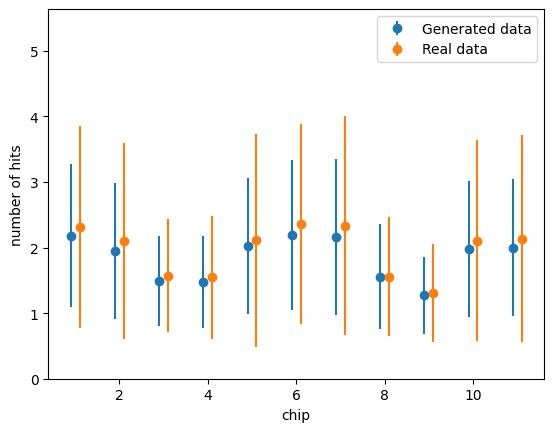

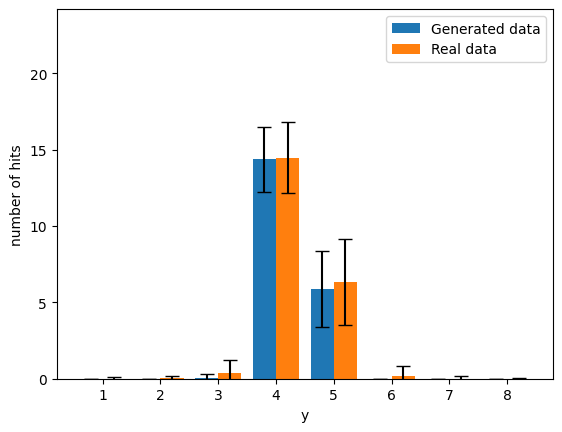

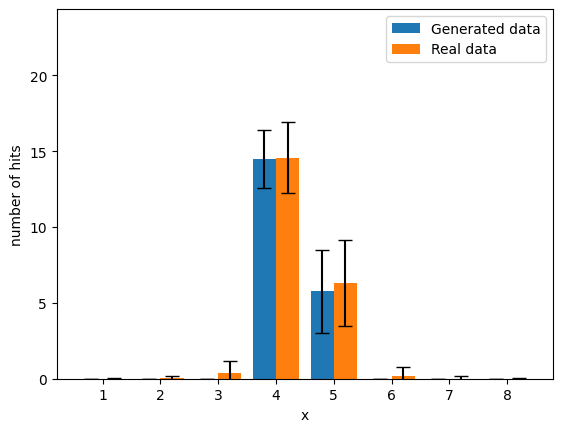

Comparison plots for epoch 145
False


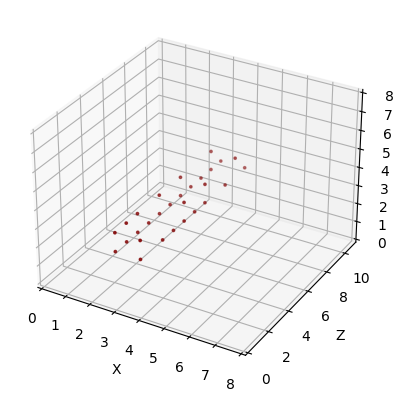

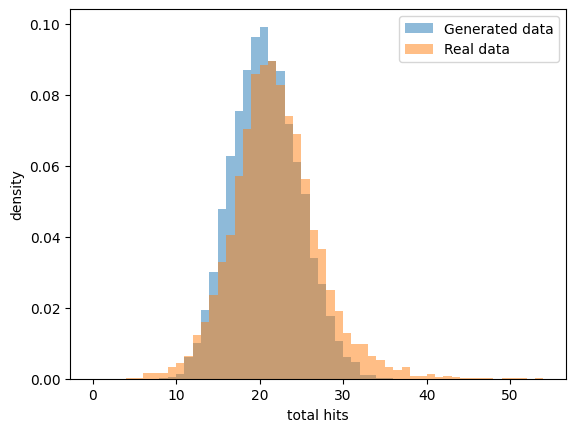

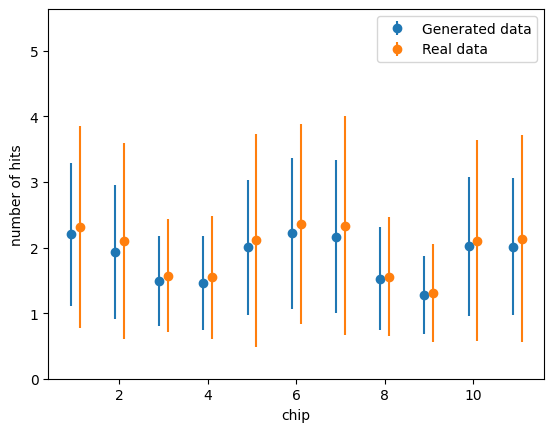

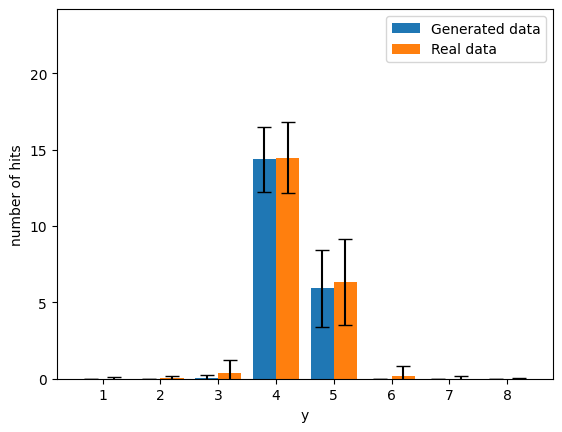

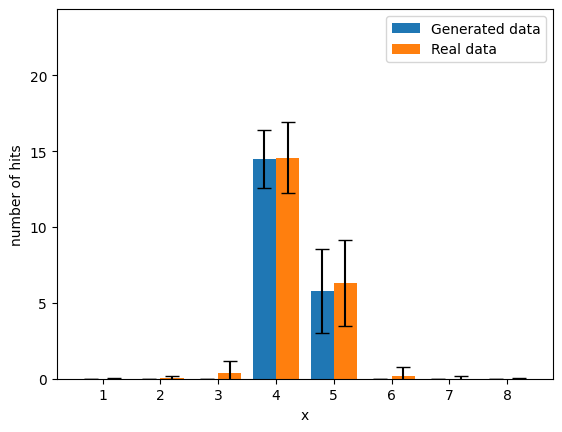

Comparison plots for epoch 150
False


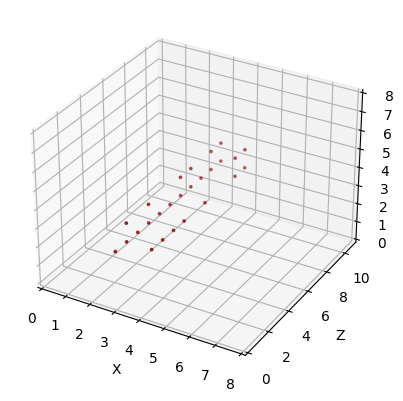

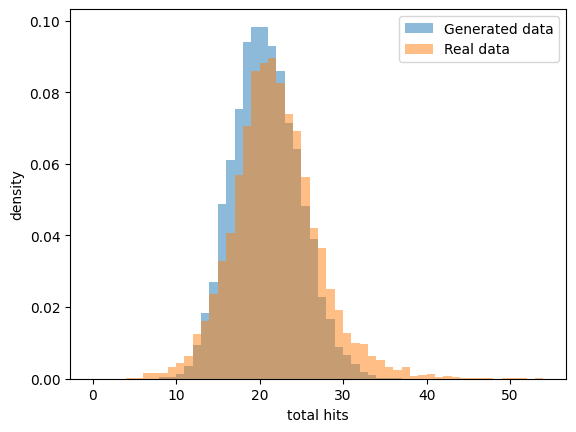

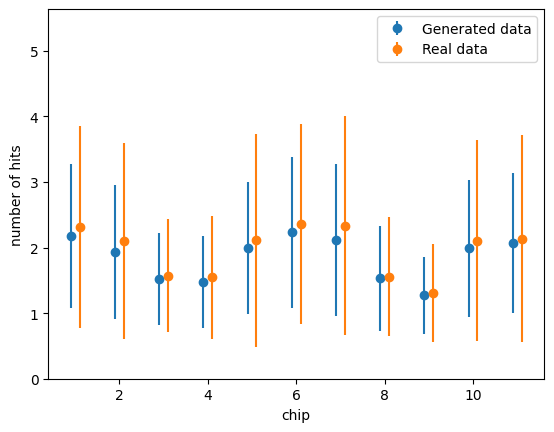

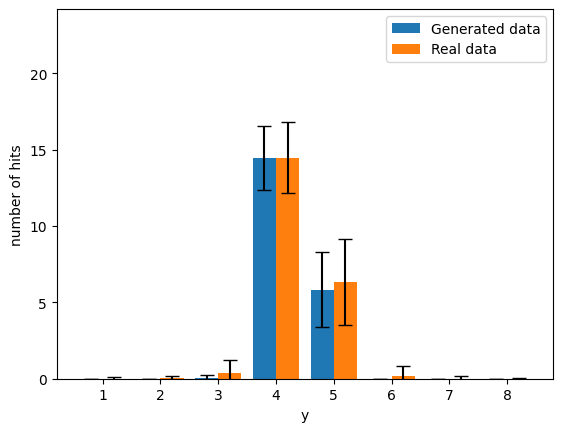

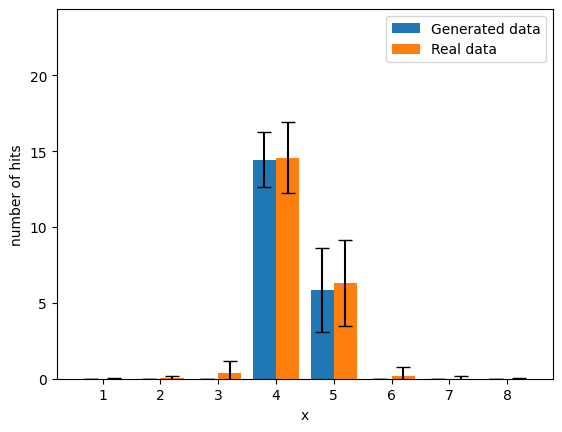

Comparison plots for epoch 155
False


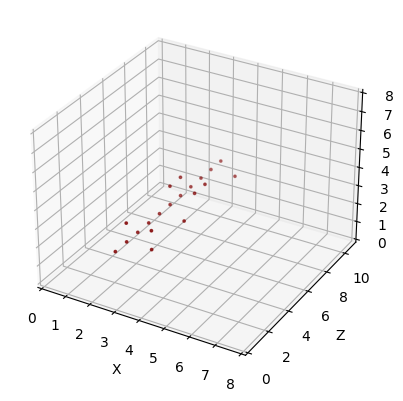

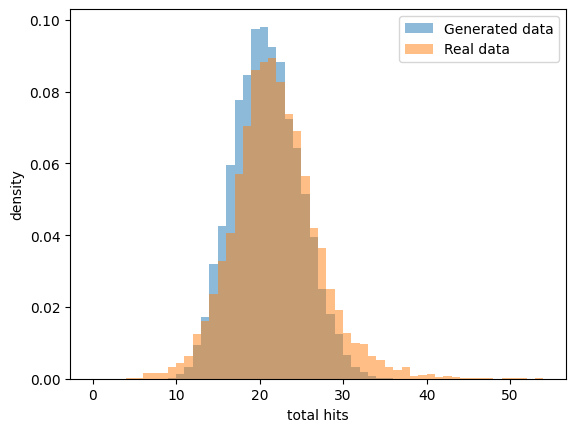

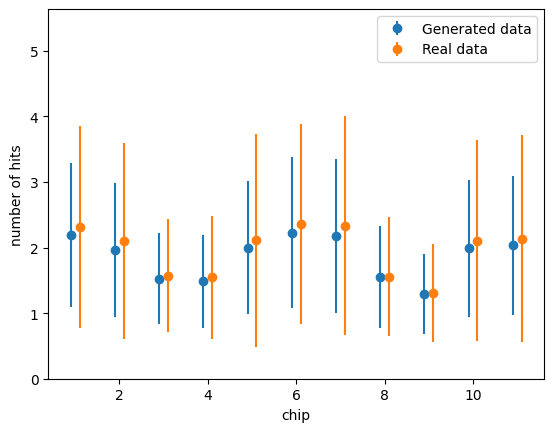

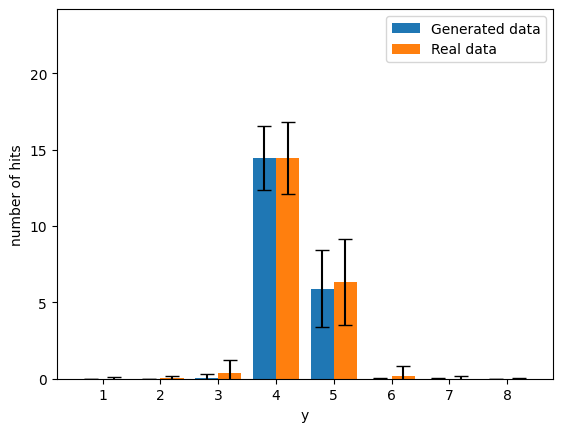

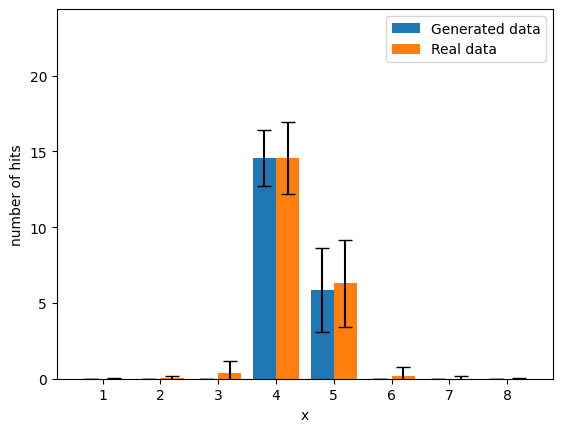

Comparison plots for epoch 160
False


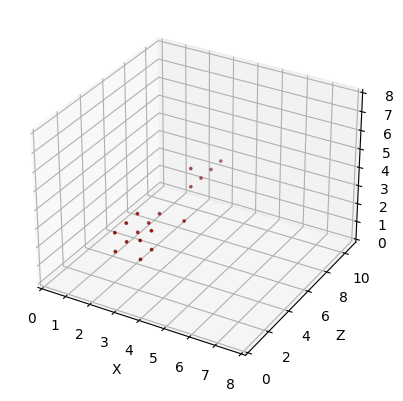

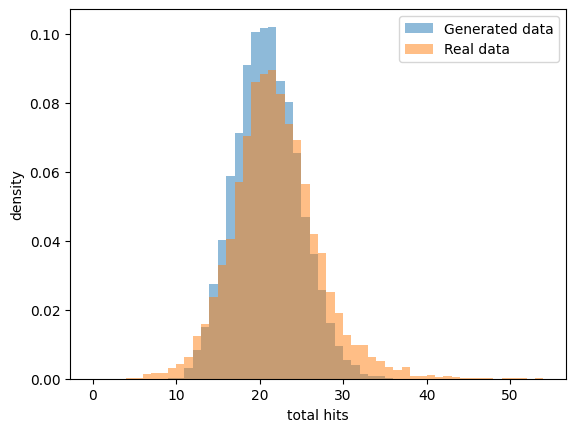

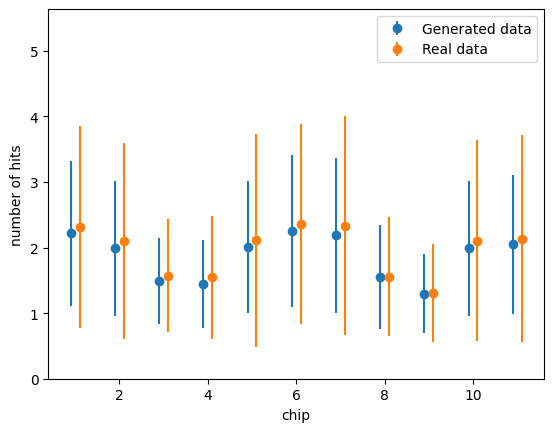

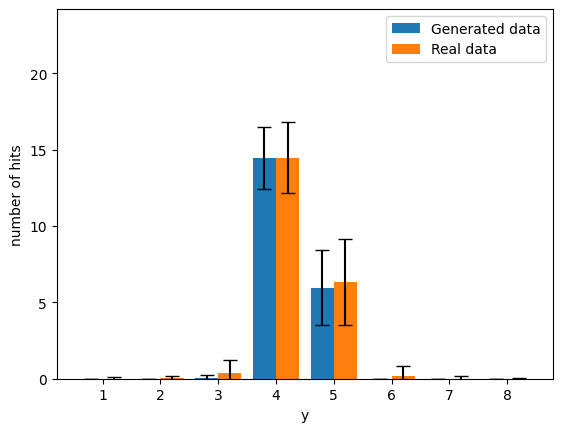

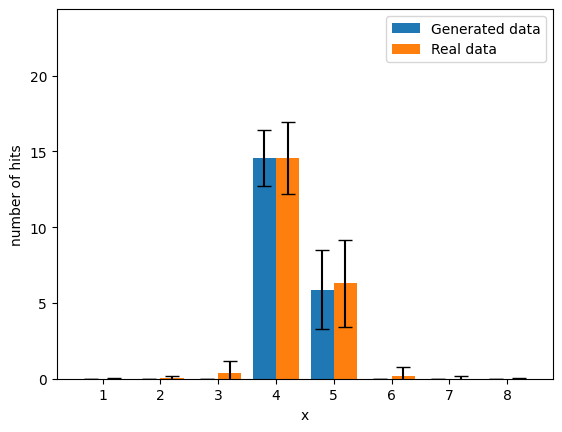

Comparison plots for epoch 165
False


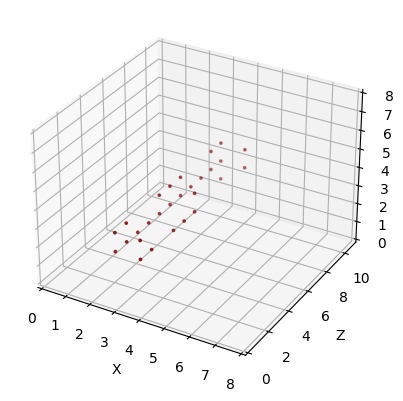

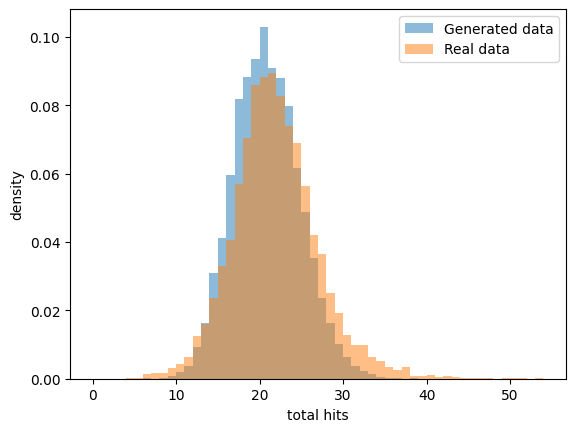

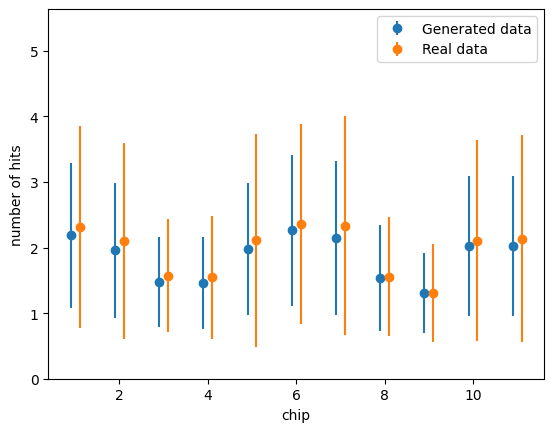

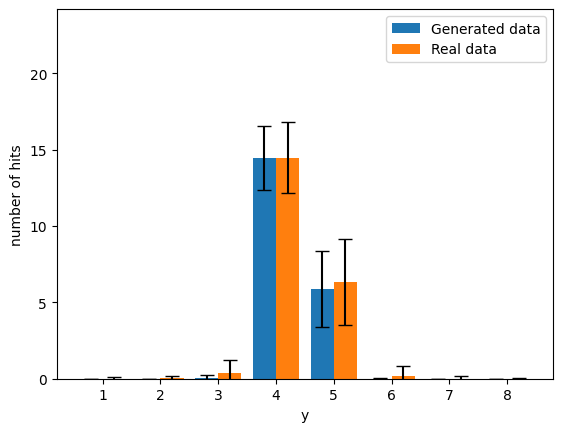

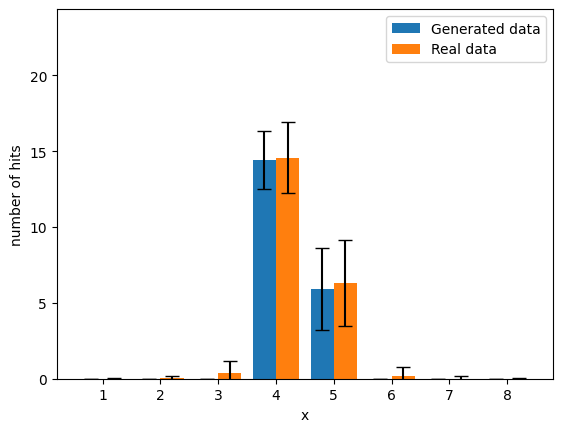

Comparison plots for epoch 170
False


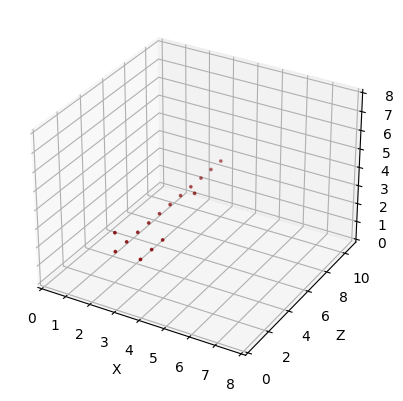

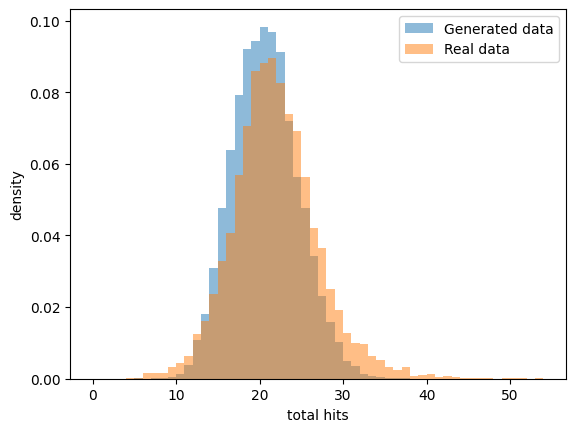

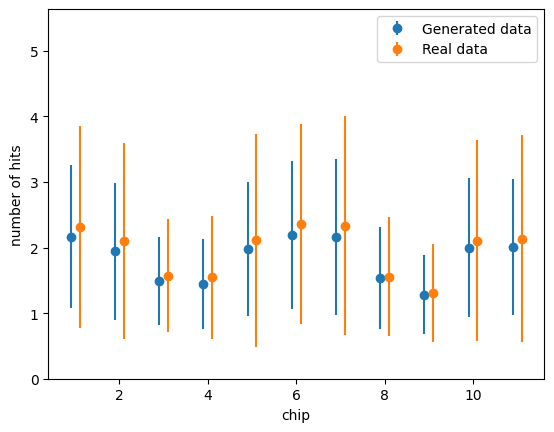

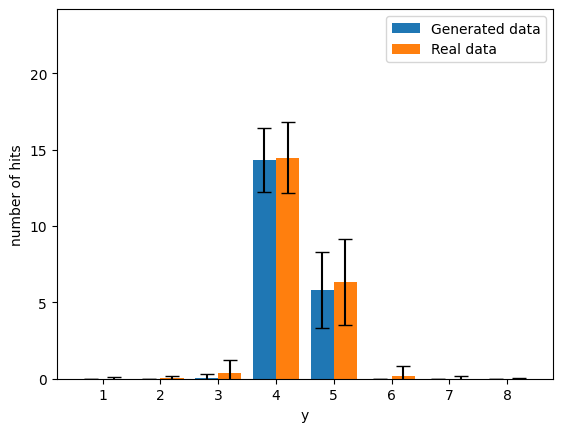

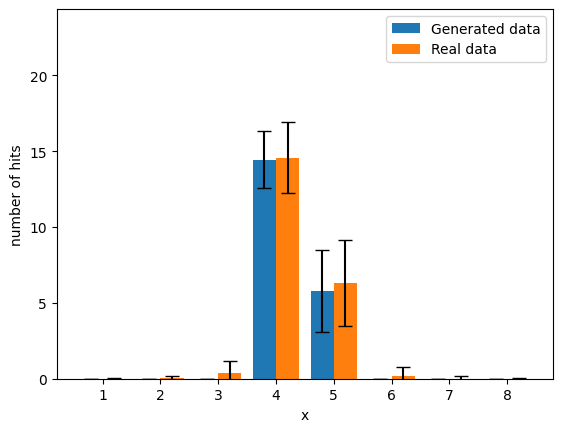

Comparison plots for epoch 175
False


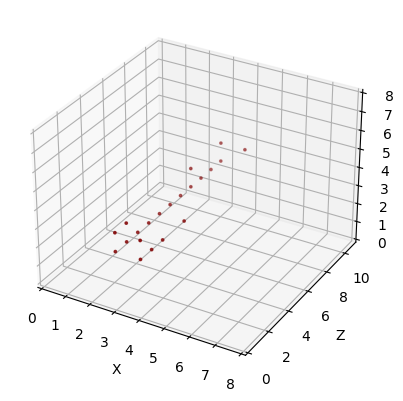

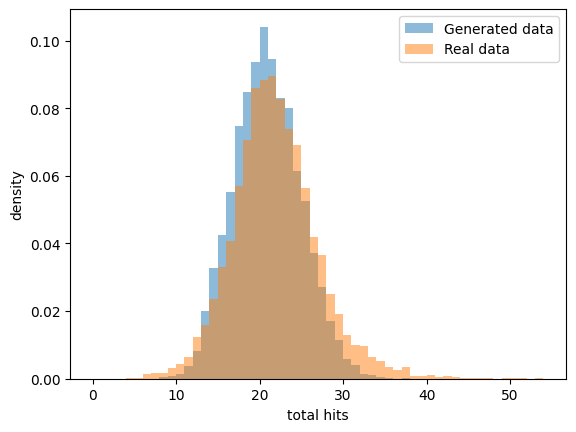

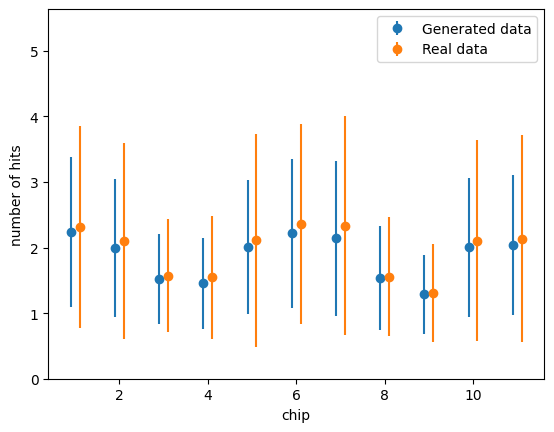

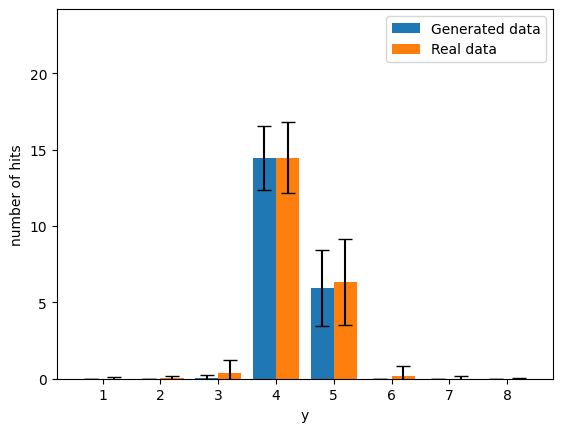

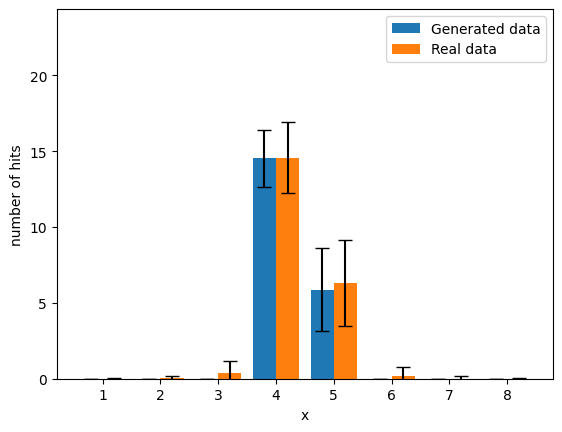

Comparison plots for epoch 180
False


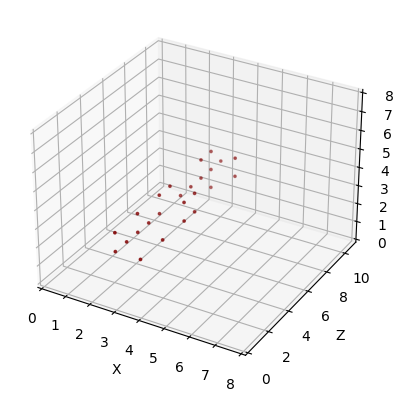

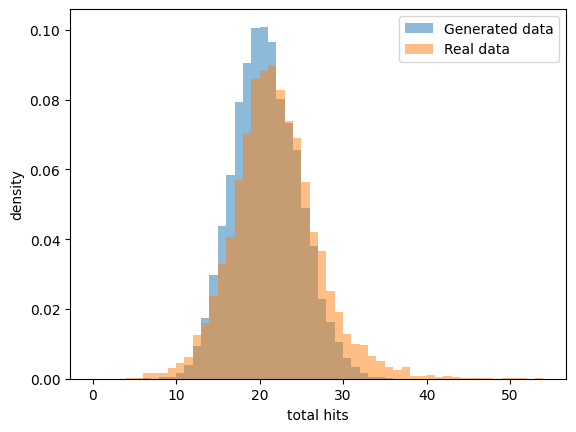

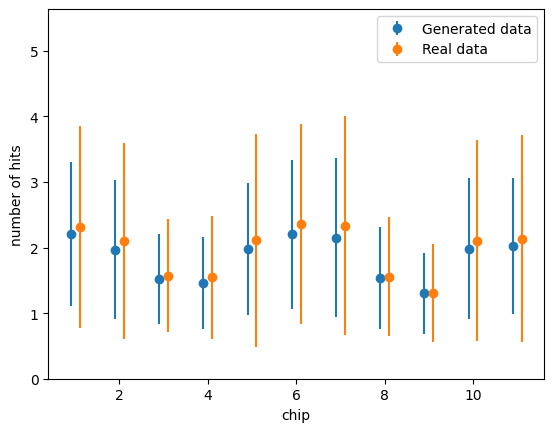

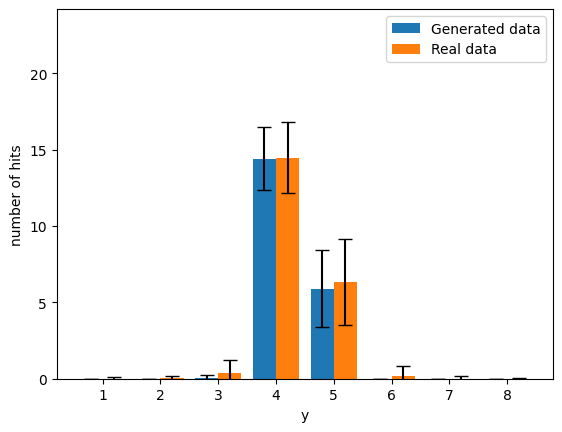

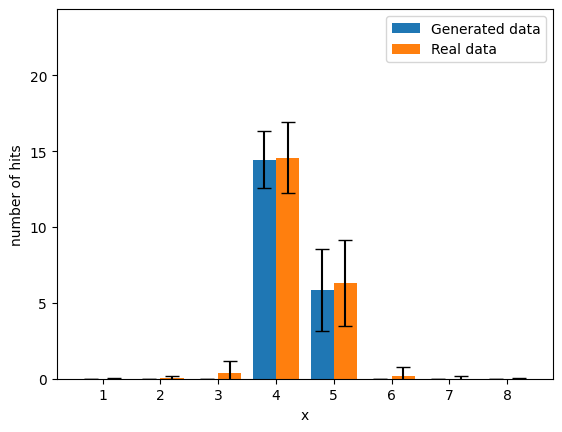

Comparison plots for epoch 185
False


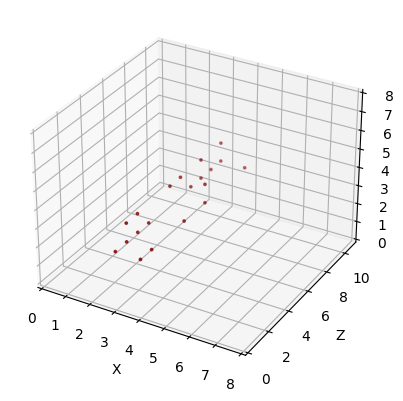

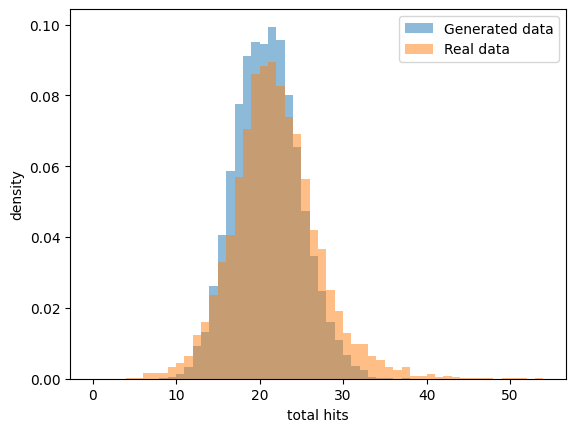

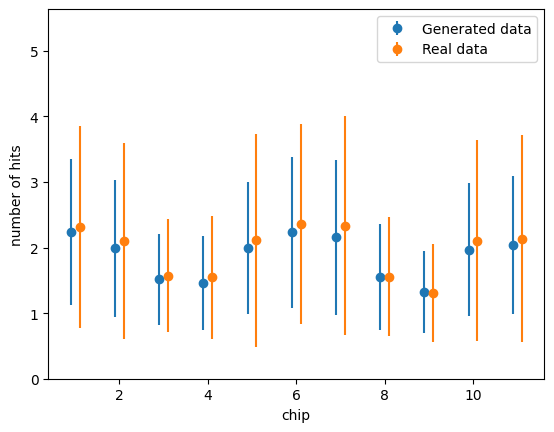

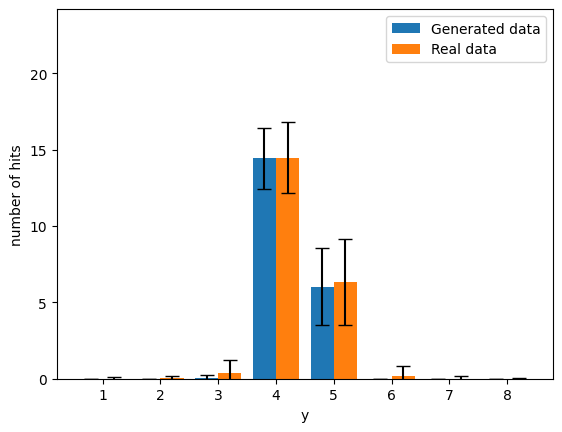

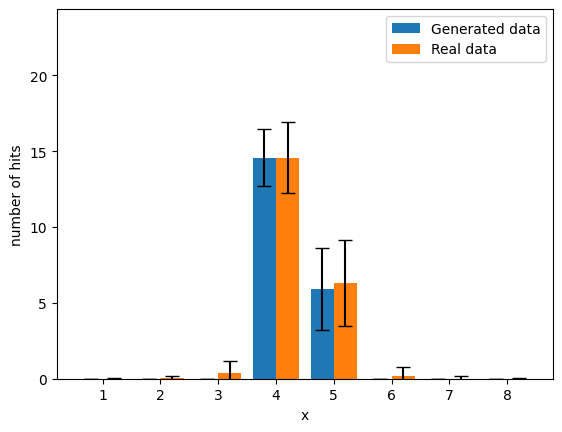

Comparison plots for epoch 190
False


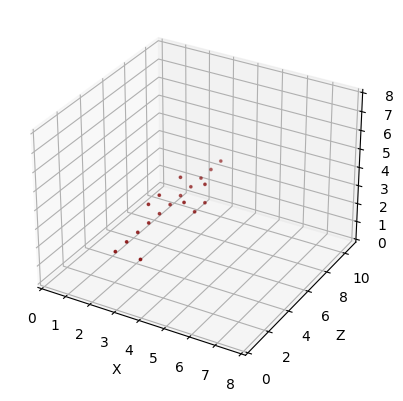

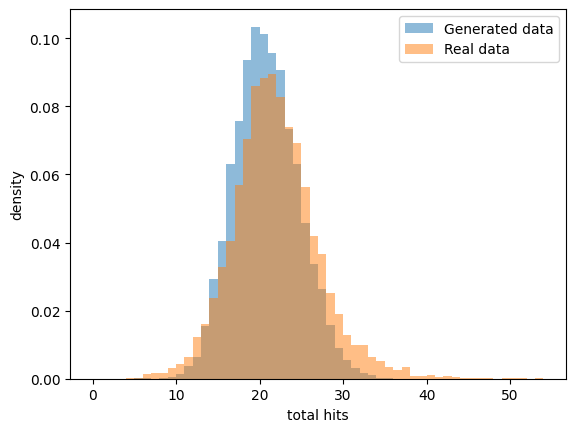

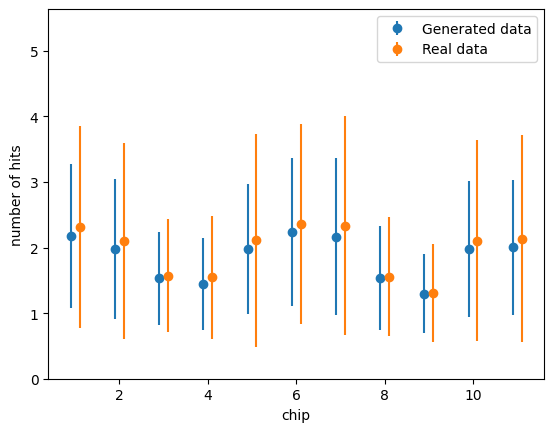

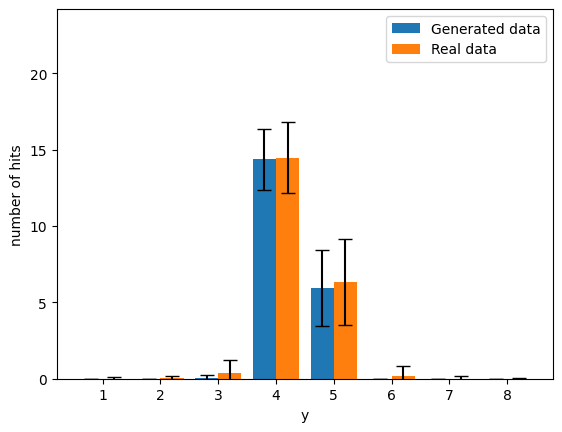

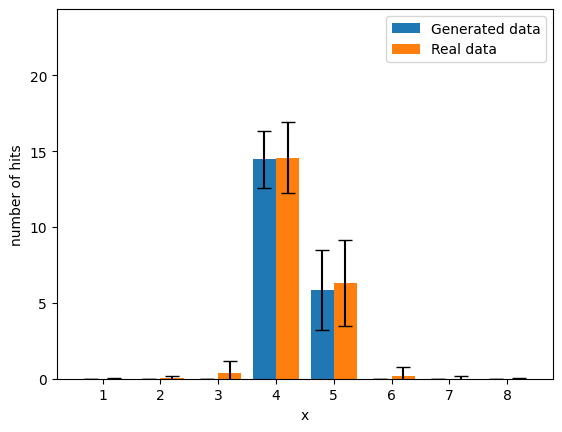

Comparison plots for epoch 195
False


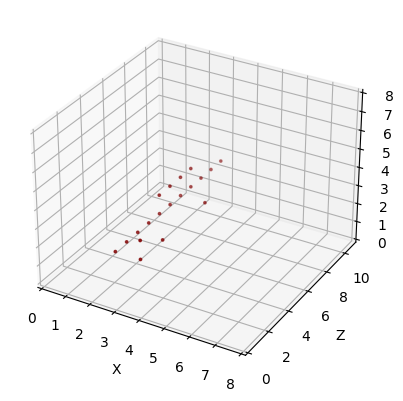

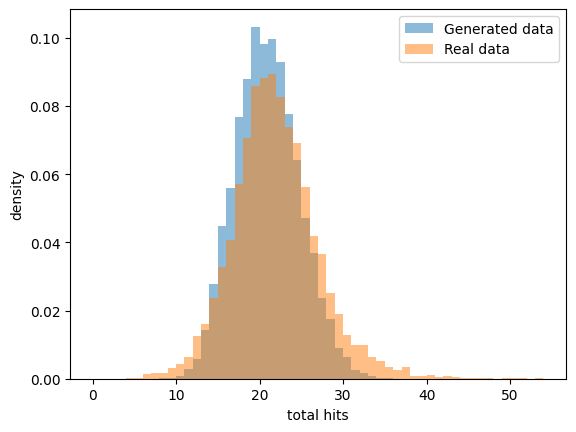

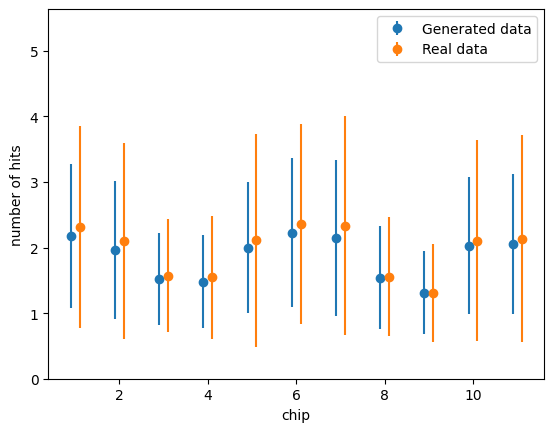

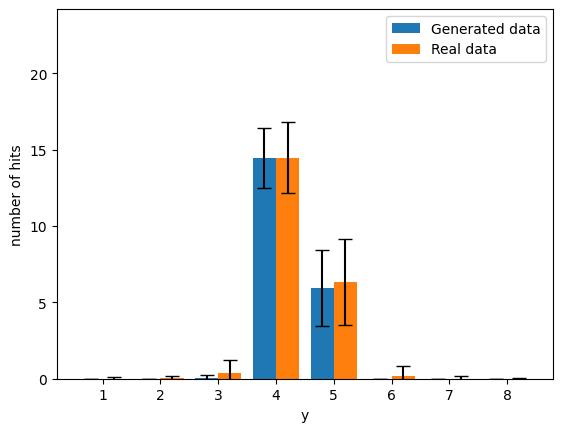

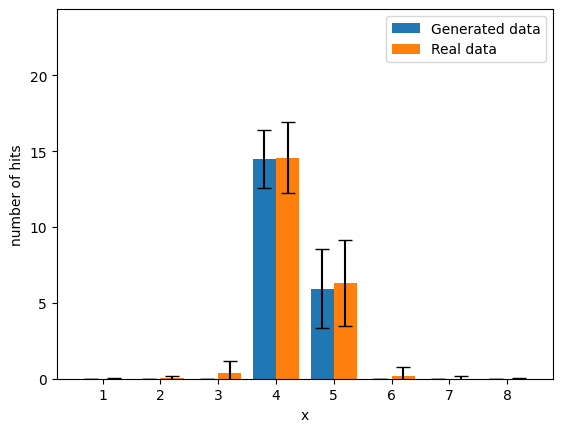

Job finished successfully!


In [9]:
# Train GAN
writer = SummaryWriter(f'{run_dir}/{experiment}')

gen.train()
disc.train()

path = f'{run_dir}/{experiment}/checkpoints/'
if not os.path.exists(path):
    os.makedirs(path)

resume_epoch = -1
for file_name in glob.glob(f'{path}/*.pth'):
    number = re.findall(r'\d+', file_name)
    if resume_epoch < int(number[-1]):
        resume_epoch = int(number[-1])

if resume_epoch >= 0:
    resume(gen, gen_optim, gen_scheduler, 
        disc, disc_optim, disc_scheduler, 
        os.path.join(path, f'epoch_{resume_epoch}.pth'))
else:
    print("Comparison plots at the starting point")
    fake_data = generate_validation_data(gen, sample_size).detach()
    fake_data = fake_data > 0.5
    fake_data = fake_data.reshape(-1, 8, 8, 11).cpu()
    fig = show_image_3d(np.array(fake_data)[0])
    writer.add_figure('example plot', fig, -1)
    fig = compare_sum_of_hits(np.array(fake_data), ACTS_dataset.pixel_hit)
    writer.add_figure('sum_of_hits', fig, -1)
    fig = compare_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(1,2), xlabel='chip')
    writer.add_figure('mean_std_chip', fig, -1)
    fig = compare_xy_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(1,3), xlabel='y')
    writer.add_figure('mean_std_y', fig, -1)
    fig = compare_xy_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(2,3), xlabel='x')
    writer.add_figure('mean_std_x', fig, -1)


for epoch in range(resume_epoch+1, n_epochs):
    disc_loss_epoch = []
    disc_real_loss_epoch = []
    disc_fake_loss_epoch = []
    disc_gradient_penalty_epoch = []
    gen_loss_epoch = []
    relative_entropy_epoch = []
    
    disc_iterations = 0
    
    bar_format="{l_bar}{bar:5}|{n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]"
    loop = tqdm(data_loader, leave = False, disable = False, bar_format = bar_format, ncols = 100)

    for real_data in loop:
        if cuda:
            real_data = real_data.view(batch_size, -1).cuda()
        else:
            real_data = real_data.view(batch_size, -1)
        # Step 1: train the discriminator
        fake_data = generate_fake_data(gen, batch_size).detach()
        if loss_function == 'cross_entropy':
            disc_loss, disc_real_loss, disc_fake_loss = cal_disc_ce_loss(disc, real_data, fake_data)
        elif loss_function == 'wasserstein_distance':
            disc_loss, disc_real_loss, disc_fake_loss, disc_gradient_penalty = cal_disc_W_loss(disc, real_data, fake_data, lambda_gp)
        else:
            raise Exception(f'{loss_function} not supported')
        
        # update the parameter
        disc_optim.zero_grad()
        disc_loss.backward()
        disc_optim.step()

        disc_iterations += 1
        disc_loss_epoch.append(disc_loss.item())
        disc_real_loss_epoch.append(disc_real_loss.item())
        disc_fake_loss_epoch.append(disc_fake_loss.item())
        disc_gradient_penalty_epoch.append(disc_gradient_penalty.item())
        
        # Step 2: train the generator
        if disc_iterations % disc_gen_ratio == 0:
            fake_data = generate_fake_data(gen, batch_size)
            if loss_function == 'cross_entropy':
                gen_loss = cal_gen_ce_loss(disc, fake_data)
            elif loss_function == 'wasserstein_distance':
                gen_loss = cal_gen_W_loss(disc, fake_data)
            else:
                raise Exception(f'{loss_function} not supported')

            # update the parameter
            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()

            gen_loss_epoch.append(gen_loss.item())
            
            loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
            loop.set_postfix({'gen_loss' : gen_loss.item(), 'dis_loss' : disc_loss.item()})

    # Record the relative entropy for each epoch
    gen_prob = np.mean(generate_validation_data(gen, sample_size).detach().cpu().numpy(), axis = 0)
    gen_prob = [1e-8 if x == 0 else x for x in gen_prob]
    writer.add_scalar('metrics/relative_entropy', entropy(real_prob, gen_prob), epoch)
    
    # Compare the mean and std for each 5 epochs
    if epoch % 5 == 0:
        print("Comparison plots for epoch {}".format(epoch))
        fake_data = generate_validation_data(gen, sample_size).detach()
        fake_data = fake_data > 0.5
        fake_data = fake_data.reshape(-1, 8, 8, 11).cpu()
        fig = show_image_3d(np.array(fake_data)[0])
        writer.add_figure('example plot', fig, epoch)
        fig = compare_sum_of_hits(np.array(fake_data), ACTS_dataset.pixel_hit)
        writer.add_figure('sum_of_hits', fig, epoch)
        fig = compare_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(1,2), xlabel='chip')
        writer.add_figure('mean_std_chip', fig, epoch)
        fig = compare_xy_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(1,3), xlabel='y')
        writer.add_figure('mean_std_y', fig, epoch)
        fig = compare_xy_mean_std(np.array(fake_data), ACTS_dataset.pixel_hit, axis=(2,3), xlabel='x')
        writer.add_figure('mean_std_x', fig, epoch)

    writer.add_scalar('loss/disc_loss', np.mean(disc_loss_epoch), epoch)
    writer.add_scalar('loss/disc_real_loss', np.mean(disc_real_loss_epoch), epoch)
    writer.add_scalar('loss/disc_fake_loss', np.mean(disc_fake_loss_epoch), epoch)
    writer.add_scalar('loss/disc_gradient_penalty', np.mean(disc_gradient_penalty_epoch), epoch)
    writer.add_scalar('loss/gen_loss', np.mean(gen_loss_epoch), epoch)
    writer.add_scalar('lr/lr_gen', np.array(gen_scheduler.get_last_lr()), epoch)
    writer.add_scalar('lr/lr_disc', np.array(disc_scheduler.get_last_lr()), epoch)
    
    # Update the learning rate
    gen_scheduler.step()
    disc_scheduler.step()

    checkpoint(gen, gen_optim, gen_scheduler,
            disc, disc_optim, disc_scheduler, 
            os.path.join(path, f'epoch_{epoch}.pth'))
    
writer.close()
torch.save(gen.state_dict(), "predictor.pkl")

print('Job finished successfully!')